In [5]:
#import os 
#os.environ['THEANO_FLAGS'] = 'optimizer_including=cudnn, force_device=True, mode=FAST_RUN, device=cuda*,linker=cvm, optimizer=fast_compile'
#print(os.path.expanduser('~/.theanorc.txt'))

In [6]:
#import theano.gpuarray as pygpu
#pygpu.test()

In [7]:
# import os
#os.environ["MKL_THREADING_LAYER"]="GNU"
#os.environ["MKL_NUM_THREADS"] = "2" 
#os.environ["NUMEXPR_NUM_THREADS"] = "2" 
#os.environ["OMP_NUM_THREADS"] = "2" 

import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as tt
from theano.tensor import fft
import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import theano.tensor.signal.conv
import exoplanet as xo
import scipy.signal

# Interpolation function needed for model

In [8]:
#Interpolation function used in model to obtain comparison points with data 
def interpolate(x0, y0, x):
    x = np.array(x)
    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d
    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

# Real data

In [6]:
# Read photometry catalogue created by my other script
photfilename = 'AKN120_out_REMIR_ROS2_phot_v02.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 11 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_2'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# Get the magnitude errors 
magerr_agn = data['MAGERR_APER_1'][:,apno]
magerr_ref1 = data['MAGERR_APER_2'][:,apno]
magerr_ref2= data['MAGERR_APER_4'][:,apno]

# Get the differential magnitudes error
delta_magerr_agn_ref1 = np.sqrt(magerr_agn**2 + magerr_ref1**2)
delta_magerr_ref2_ref1 = np.sqrt(magerr_ref2**2 + magerr_ref1**2)
errlim = 0.1 #max error value

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
maskJ = (filt == 'J')
#J band data
#Remove NaN
Jtemp=delta_mag_agn_ref1[maskJ]
Jisnan=~np.isnan(Jtemp)
xJ=np.asarray(mjd_obs[maskJ][Jisnan], dtype=float)
nJ=len(xJ)
XJ = np.reshape(xJ,(nJ,1))
yJ=np.asarray(delta_mag_agn_ref1[maskJ][Jisnan]-np.median(delta_mag_agn_ref1[maskJ][Jisnan]), dtype=float)
yJerr = np.asarray(delta_magerr_agn_ref1[maskJ][Jisnan], dtype=float)
#Remove >errlim mag errors
xJ=xJ[yJerr<errlim]
nJ=len(xJ)
XJ = np.reshape(xJ,(nJ,1))
yJ=yJ[yJerr<errlim]
yJerr = yJerr[yJerr<errlim]


#H band data
#Remove NaN
maskH = (filt == 'H')
Htemp=delta_mag_agn_ref1[maskH]
Hisnan=~np.isnan(Htemp)
xH=np.asarray(mjd_obs[maskH][Hisnan], dtype=float)
nH=len(xH)
XH = np.reshape(xH,(nH,1))
yH=np.asarray(delta_mag_agn_ref1[maskH][Hisnan]-np.median(delta_mag_agn_ref1[maskH][Hisnan]), dtype=float)
yHerr = np.asarray(delta_magerr_agn_ref1[maskH][Hisnan], dtype=float)
#Remove >errlim mag errors
xH=xH[yHerr<errlim]
nH=len(xH)
XH = np.reshape(xH,(nH,1))
yH=yH[yHerr<errlim]
yHerr = yHerr[yHerr<errlim]

#K band data
#Remove NaN
maskK = (filt == 'K')
Ktemp=delta_mag_agn_ref1[maskK]
Kisnan=~np.isnan(Ktemp)
xK=np.asarray(mjd_obs[maskK][Kisnan], dtype=float)
nK=len(xK)
XK = np.reshape(xK,(nK,1))
yK=np.asarray(delta_mag_agn_ref1[maskK][Kisnan]-np.median(delta_mag_agn_ref1[maskK][Kisnan]), dtype=float)
yKerr = np.asarray(delta_magerr_agn_ref1[maskK][Kisnan], dtype=float)
#Remove >errlim mag errors
xK=xK[yKerr<errlim]
nK=len(xK)
XK = np.reshape(xK,(nK,1))
yK=yK[yKerr<errlim]
yKerr = yKerr[yKerr<errlim]

#g band data
#Remove NaN
maskg = (filt == 'g')
gtemp=delta_mag_agn_ref1[maskg]
gisnan=~np.isnan(gtemp)
xg=np.asarray(mjd_obs[maskg][gisnan], dtype=float)
ng=len(xg)
Xg = np.reshape(xg,(ng,1))
yg=np.asarray(delta_mag_agn_ref1[maskg][gisnan]-np.median(delta_mag_agn_ref1[maskg][gisnan]), dtype=float)
ygerr = np.asarray(delta_magerr_agn_ref1[maskg][gisnan], dtype=float)
#Remove >errlim mag errors
xg=xg[ygerr<errlim]
ng=len(xg)
Xg = np.reshape(xg,(ng,1))
yg=yg[ygerr<errlim]
ygerr = ygerr[ygerr<errlim]
#remove values 
xg=xg[(yg>-0.4) & (yg<0.4)]
ng=len(xg)
Xg = np.reshape(xg,(ng,1))
ygerr=ygerr[(yg>-0.4) & (yg<0.4)]
yg=yg[(yg>-0.4) & (yg<0.4)]

#r band data
#Remove NaN
maskr = (filt == 'r')
rtemp=delta_mag_agn_ref1[maskr]
risnan=~np.isnan(rtemp)
xr=np.asarray(mjd_obs[maskr][risnan], dtype=float)
nr=len(xr)
Xr = np.reshape(xr,(nr,1))
yr=np.asarray(delta_mag_agn_ref1[maskr][risnan]-np.median(delta_mag_agn_ref1[maskr][risnan]), dtype=float)
yrerr = np.asarray(delta_magerr_agn_ref1[maskr][risnan], dtype=float)
#Remove >errlim mag errors
xr=xr[yrerr<errlim]
nr=len(xr)
Xr = np.reshape(xr,(nr,1))
yr=yr[yrerr<errlim]
yrerr = yrerr[yrerr<errlim]
#remove values 
xr=xr[(yr>-0.4) & (yr<0.4)]
nr=len(xr)
Xr = np.reshape(xr,(nr,1))
yrerr=yrerr[(yr>-0.4) & (yr<0.4)]
yr=yr[(yr>-0.4) & (yr<0.4)]

#i band data
#Remove NaN
maski = (filt == 'i')
itemp=delta_mag_agn_ref1[maski]
iisnan=~np.isnan(itemp)
xi=np.asarray(mjd_obs[maski][iisnan], dtype=float)
ni=len(xi)
Xi = np.reshape(xi,(ni,1))
yi=np.asarray(delta_mag_agn_ref1[maski][iisnan]-np.median(delta_mag_agn_ref1[maski][iisnan]), dtype=float)
yierr = np.asarray(delta_magerr_agn_ref1[maski][iisnan], dtype=float)
#Remove >errlim mag errors
xi=xi[yierr<errlim]
ni=len(xi)
Xi = np.reshape(xi,(ni,1))
yi=yi[yierr<errlim]
yierr = yierr[yierr<errlim]
#remove values 
xi=xi[(yi>-0.4) & (yi<0.4)]
ni=len(xi)
Xi= np.reshape(xi,(ni,1))
yierr=yierr[(yi>-0.4) & (yi<0.4)]
yi=yi[(yi>-0.4) & (yi<0.4)]

#z band data
#Remove NaN
maskz = (filt == 'z')
ztemp=delta_mag_agn_ref1[maskz]
zisnan=~np.isnan(ztemp)
xz=np.asarray(mjd_obs[maskz][zisnan], dtype=float)
nz=len(xz)
Xz = np.reshape(xz,(nz,1))
yz=np.asarray(delta_mag_agn_ref1[maskz][zisnan]-np.median(delta_mag_agn_ref1[maskz][zisnan]), dtype=float)
yzerr = np.asarray(delta_magerr_agn_ref1[maskz][zisnan], dtype=float)
#Remove >errlim mag errors
xz=xz[yzerr<errlim]
nz=len(xz)
Xz = np.reshape(xz,(nz,1))
yz=yz[yzerr<errlim]
yzerr = yzerr[yzerr<errlim]
#remove values 
xz=xz[(yz>-0.4) & (yz<0.4)]
nz=len(xz)
Xz = np.reshape(xz,(nz,1))
yzerr=yzerr[(yz>-0.4) & (yz<0.4)]
yz=yz[(yz>-0.4) & (yz<0.4)]

#time array with all bands
#be carefull with how XJ and xj acts 
X_tot= np.concatenate((xJ,xH,xK,xg,xr,xi,xz),axis=None)
X_tot=np.reshape(X_tot,(len(X_tot),1))

#combine all y values for guess
Y_tot= np.concatenate((yJ,yH,yK),axis=None)

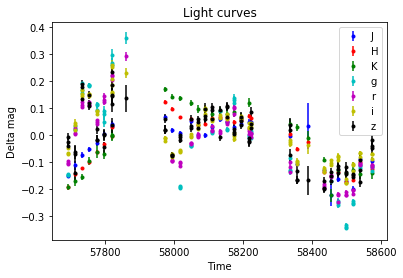

In [7]:
plt.errorbar(xJ, yJ, yJerr,fmt='b.',label='J')
plt.errorbar(xH, yH, yHerr,fmt='r.',label='H')
plt.errorbar(xK, yK, yKerr,fmt='g.',label='K')
plt.errorbar(xg, yg, ygerr,fmt='c.',label='g')
plt.errorbar(xr, yr, yrerr,fmt='m.',label='r')
plt.errorbar(xi, yi, yierr,fmt='y.',label='i')
plt.errorbar(xz, yz, yzerr,fmt='k.',label='z')
#plt.ylim(-1,1)
plt.title('Light curves')
plt.xlabel('Time')
plt.ylabel('Delta mag')
plt.legend()

In [8]:
print('J:',min(yJerr),max(yJerr))
print('H:',min(yHerr),max(yHerr))
print('K:',min(yKerr),max(yKerr))
print('g:',min(ygerr),max(ygerr))
print('r:',min(yrerr),max(yrerr))
print('i:',min(yierr),max(yierr))
print('z:',min(yzerr),max(yzerr))

J: 0.008091012947261333 0.08507400751113892
H: 0.005026146769523621 0.021889466792345047
K: 0.00830292422324419 0.028971072286367416
g: 0.004995673894882202 0.02168060839176178
r: 0.003855181625112891 0.0160375963896513
i: 0.004945984110236168 0.031422946602106094
z: 0.011396097019314766 0.05310756340622902


# Simulated data

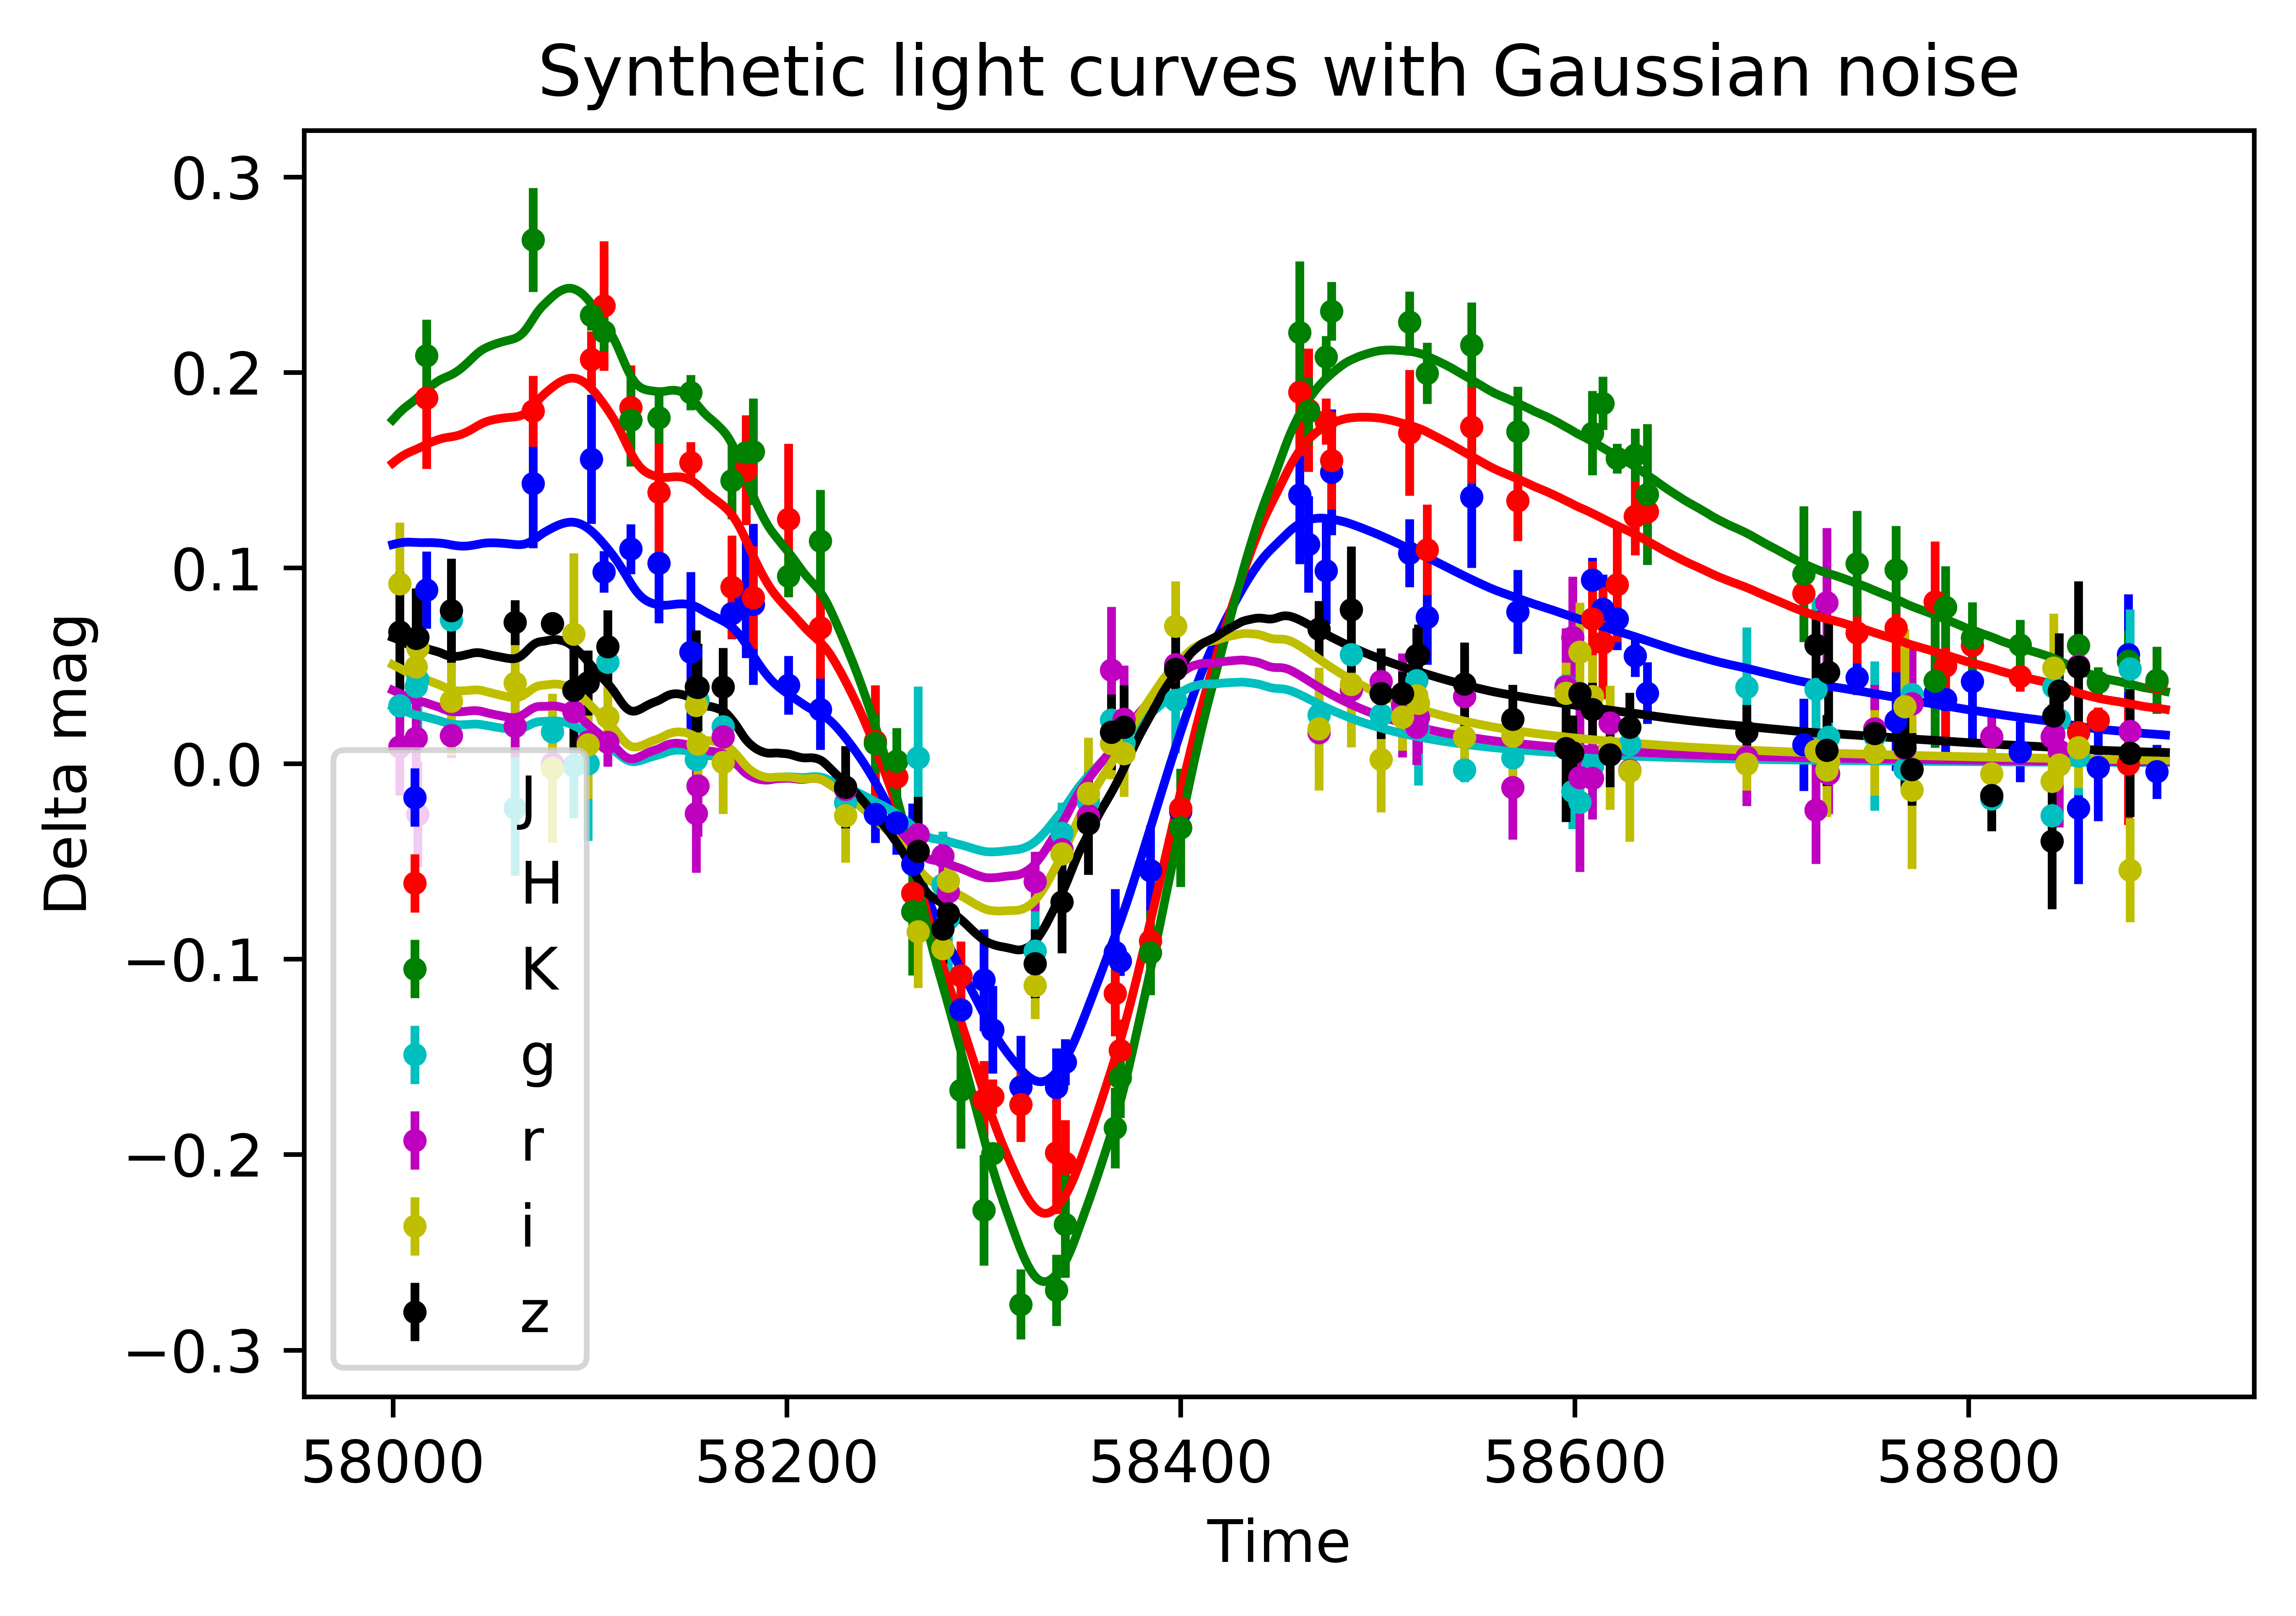

In [177]:
import random
yJ,yJerr = np.loadtxt('Jband.txt', delimiter=',', usecols=(0,1), unpack=True)
yH,yHerr = np.loadtxt('Hband.txt', delimiter=',', usecols=(0,1), unpack=True)
yK,yKerr = np.loadtxt('Kband.txt', delimiter=',', usecols=(0,1), unpack=True)
yg,ygerr = np.loadtxt('gband.txt', delimiter=',', usecols=(0,1), unpack=True)
yr,yrerr = np.loadtxt('rband.txt', delimiter=',', usecols=(0,1), unpack=True)
yi,yierr = np.loadtxt('iband.txt', delimiter=',', usecols=(0,1), unpack=True)
yz,yzerr = np.loadtxt('zband.txt', delimiter=',', usecols=(0,1), unpack=True)

yJplot=yJ
yHplot=yH
yKplot=yK
ygplot=yg
yrplot=yr
yiplot=yi
yzplot=yz
X=np.linspace(58000,58900,1000)

import scipy.stats as stats

lower, upper = 0.005, 0.1
mu, sigma = 0.02,0.01


n_list = 49# Number of selected points
noise_scale=0.1
yJerr=stats.truncnorm.rvs((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma,size=n_list)#np.random.uniform(low=0.0005,high=noise_scale,size=n_list)
yHerr=stats.truncnorm.rvs((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma,size=n_list)#np.random.uniform(low=0.0005,high=noise_scale,size=n_list
yKerr=stats.truncnorm.rvs((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma,size=n_list)#np.random.uniform(low=0.0005,high=noise_scale,size=n_list)
ygerr=stats.truncnorm.rvs((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma,size=n_list)#np.random.uniform(low=0.0005,high=noise_scale,size=n_list)
yrerr=stats.truncnorm.rvs((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma,size=n_list)#np.random.uniform(low=0.0005,high=noise_scale,size=n_list)
yierr=stats.truncnorm.rvs((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma,size=n_list)#np.random.uniform(low=0.0005,high=noise_scale,size=n_list)
yzerr=stats.truncnorm.rvs((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma,size=n_list)#np.random.uniform(low=0.0005,high=noise_scale,size=n_list)

the_list = list(range(len(X)))
ind = random.sample(the_list, n_list)
ind2 = random.sample(the_list, n_list) 

yJ=yJ[ind]
XJ=X[ind]
yH=yH[ind]
XH=X[ind]
yK=yK[ind]
XK=X[ind]
yg=yg[ind2]
Xg=X[ind2]
yr=yr[ind2]
Xr=X[ind2]
yi=yi[ind2]
Xi=X[ind2]
yz=yz[ind2]
Xz=X[ind2]

for i in range(0,n_list):
    yJ[i]=yJ[i] + np.random.normal(0,yJerr[i])
    yH[i]=yH[i] + np.random.normal(0,yHerr[i])
    yK[i]=yK[i] + np.random.normal(0,yKerr[i])
    yg[i]=yg[i] + np.random.normal(0,ygerr[i])
    yr[i]=yr[i] + np.random.normal(0,yrerr[i])
    yi[i]=yi[i] + np.random.normal(0,yierr[i])
    yz[i]=yz[i] + np.random.normal(0,yzerr[i])

    
X_tot=[XJ,XH,XK,Xg,Xr,Xi,Xz]

plt.figure(dpi=1000)
plt.errorbar(XJ, yJ, yJerr, fmt='b.', label='J')
plt.plot(X,yJplot,'b')
plt.errorbar(XH, yH, yHerr, fmt='r.', label='H')
plt.plot(X,yHplot,'r')
plt.errorbar(XK, yK, yKerr, fmt='g.', label='K')
plt.plot(X,yKplot,'g')
plt.errorbar(Xg, yg, ygerr, fmt='c.', label='g')
plt.plot(X,ygplot,'c')
plt.errorbar(Xr, yr, yrerr, fmt='m.', label='r')
plt.plot(X,yrplot,'m')
plt.errorbar(Xi, yi, yierr, fmt='y.', label='i')
plt.plot(X,yiplot,'y')
plt.errorbar(Xz, yz, yzerr, fmt='k.', label='z')
plt.plot(X,yzplot,'k')
plt.title('Synthetic light curves with Gaussian noise')
plt.xlabel('Time')
plt.ylabel('Delta mag')
plt.legend()

(array([ 5.,  7.,  3., 10.,  6.,  9.,  5.,  2.,  1.,  1.]),
 array([0.00580323, 0.00991807, 0.0140329 , 0.01814774, 0.02226258,
        0.02637741, 0.03049225, 0.03460709, 0.03872192, 0.04283676,
        0.0469516 ]),
 <a list of 10 Patch objects>)

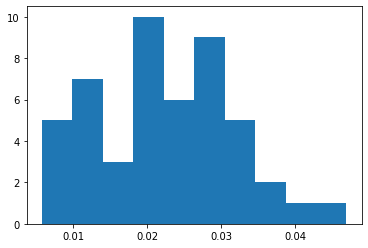

In [178]:
plt.hist(ygerr)

In [179]:
Xdriv,ydriv = np.loadtxt('drivingfunction.txt', delimiter=',', usecols=(0,1), unpack=True)

time values are saved as "X" and magnitude values are saved as "f_true"


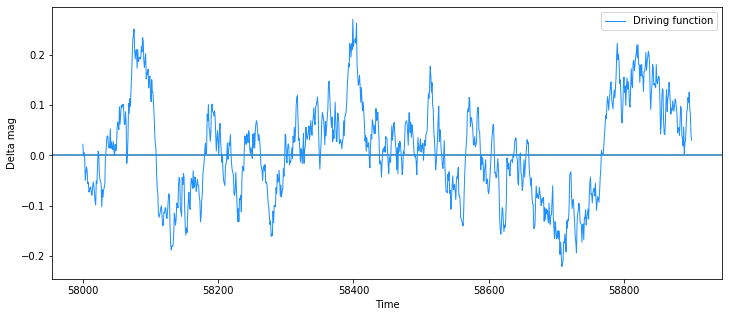

In [219]:
## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plt.axhline(y=0)
ax.plot(Xdriv, ydriv, "dodgerblue", lw=1, label="Driving function");
#ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("Time"); ax.set_ylabel("Delta mag"); plt.legend();
print('time values are saved as "X" and magnitude values are saved as "f_true"')

# GP and prior infomation

In [183]:
#array for GP
nGP=499
XGP=np.linspace(np.min(X_tot)-1.0,np.max(X_tot)+1.0,nGP)
print((max(XGP)-min(XGP))/nGP)
XGP=np.reshape(XGP,(len(XGP),1))
#time delay array
ntau=nGP
tau=np.linspace(0.001,170.0,ntau)

1.7913665168174218


In [184]:
mlow=np.log(10.0)
mhigh=np.log(60.0)
mmu=(mhigh+mlow)/2.0
msig=(mhigh-mlow)/2.0

mlowV=np.log(1.0)
mhighV=np.log(20.0)
mmuV=(mhigh+mlow)/2.0
msigV=(mhigh-mlow)/2.0

siglow=0.5
sighigh=2.0
sigmu=(sighigh+siglow)/2.0
sigsig=(sighigh-siglow)/2.0

In [189]:
#print(np.std(yJ),np.std(yH),np.std(yK),np.std(yg),np.std(yr),np.std(yi),np.std(yz))
stdy=[np.std(yJ),np.std(yH),np.std(yK),np.std(yg),np.std(yr),np.std(yi),np.std(yz)]
#print(np.mean(stdy))
print(np.log(np.mean(stdy)))
#print(np.log(np.std([np.std(yJ),np.std(yH),np.std(yK),np.std(yg),np.std(yr),np.std(yi),np.std(yz)])))
print((np.log(max(stdy))-np.log(min(stdy)))/2)
#print(np.var(yJ),np.var(yH),np.var(yK),np.var(yg),np.var(yr),np.var(yi),np.var(yz))
#print(np.mean([np.var(yJ),np.var(yH),np.var(yK),np.var(yg),np.var(yr),np.var(yi),np.var(yz)]))
#print(np.std([np.var(yJ),np.var(yH),np.var(yK),np.var(yg),np.var(yr),np.var(yi),np.var(yz)]))
print(np.log(0.1))
#print(np.log(stdy))

-2.6374252677060595
0.8015919863128241
-2.3025850929940455


In [211]:
with pm.Model() as convmodel:
    ############################################
    #define driving function as Gaussian Process
    ############################################
    #find way to use g band as first guess of value 
    ℓ = 15.0 + pm.Normal('ℓ', mu=0.0, sigma=5.0)#timescale of variation for the driving function, order of days for UV
    #REMEMBER time scale is 2*ℓ^2 so remember to rewrite as ℓ_true=2*ℓ^2
    η = tt.exp(-2.64 + pm.Normal('η', mu=0.0, sigma=0.8))#pm.Bound(pm.HalfNormal, upper=0.6)('η',sigma=0.3)#pm.Bound(pm.Normal, lower=0.0,upper=0.6)('η', mu=0.3, sigma=0.3)#long term standard deviation for the driving function
    cov = η**2 * pm.gp.cov.Exponential(1, ls=ℓ)#using same cov as light curve interpolation
    gp = pm.gp.Latent(cov_func=cov)
    #f = gp.prior("f", X=XGP,reparameterize = False)
    f = gp.prior("f", X=XGP)
    f = f.reshape((1,1,len(XGP),1))
    ##############
    #Define priors
    ##############

    #Universal Dusty Torus parameters for the uniform temperature DT
    sigma_DT=sigmu+pm.Normal('sigma_DT', mu=0.0, sigma=sigsig)#needs a source for scale
    m_DT= mmu + pm.Normal('m_DT', mu=0.0, sigma=msig)#we expect serveral tens to hundreds of days from the nature letter
    #theta_DT= 0.0#tmu + pm.Normal('theta_DT', mu=0.0,sigma=tsig)#add later when simple model is staple
    #Accretion Disk paramters
    #J band
    Jsigma_AD=sigmu+pm.Normal('Jsigma_AD', mu=0.0,sigma=sigsig)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    #Jtheta_AD=0.0#pm.Normal('Jtheta_AD',mu=0.0,sigma=10.0)#add later 
    Jm_AD=mmuV+pm.Normal('Jm_AD', mu=0.0 ,sigma=msig)#AD has 3-5 times smaller lags than DT 
    #H band
    Hsigma_AD=sigmu+pm.Normal('Hsigma_AD', mu=0.0,sigma=sigsig)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    #Htheta_AD=0.0#pm.Normal('Htheta_AD',mu=0.0,sigma=10.0)#add later 
    Hm_AD=mmuV+pm.Normal('Hm_AD', mu=0.0,sigma=msig)#AD has 3-5 times smaller lags than DT 
    #K band
    Ksigma_AD=sigmu+pm.Normal('Ksigma_AD', mu=0.0, sigma=sigsig)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    #Ktheta_AD=0.0#pm.Normal('Ktheta_AD',mu=0.0,sigma=10.0)#add later 
    Km_AD=mmuV+ pm.Normal('Km_AD', mu=0.0, sigma=msig)#AD has 3-5 times smaller lags than DT  
    #g band
    gsigma_AD=sigmu+pm.Normal('gsigma_AD', mu=0.0,sigma=sigsig)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    #gtheta_AD=0.0#pm.Normal('gtheta_AD',mu=0.0,sigma=10.0)#add later 
    gm_AD=mmuV+pm.Normal('gm_AD', mu=0.0 ,sigma=msigV)#AD has 3-5 times smaller lags than DT  
    #r band
    rsigma_AD=sigmu+pm.Normal('rsigma_AD', mu=0.0,sigma=sigsig)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    #rtheta_AD=0.0#pm.Normal('rtheta_AD',mu=0.0,sigma=10.0)#add later 
    rm_AD=mmuV+pm.Normal('rm_AD', mu=0.0 ,sigma=msigV)#AD has 3-5 times smaller lags than DT  
    #i band
    isigma_AD=sigmu+pm.Normal('isigma_AD', mu=0.0, sigma=sigsig)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    #itheta_AD=0.0#pm.Normal('gtheta_AD',mu=0.0,sigma=10.0)#add later 
    im_AD=mmuV+pm.Normal('im_AD', mu=0.0, sigma=msigV)#AD has 3-5 times smaller lags than DT 
    #z band
    zsigma_AD=sigmu+pm.Normal('zsigma_AD', mu=0.0,sigma=sigsig)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    #ztheta_AD=0.0#pm.Normal('ztheta_AD',mu=0.0,sigma=10.0)#add later 
    zm_AD=mmuV+pm.Normal('zm_AD', mu=0.0 ,sigma=msigV)#AD has 3-5 times smaller lags than DT
    #BB and power law parameters
    T=7.32420984045+pm.Normal('T',mu=0.0,sigma=0.41645456146)#taken from nature letter
    K_0=pm.Normal('K_0', mu=0, sigma=2.3)#powr/BB
    index=1.5+pm.Normal('index', mu=0.0, sigma=0.5)#sign depends on diffmag definition change to -2 to -1
    #Note for index: we have taken the transformation from F_nu to F_lamb into account with the index value.
                         
    #Different wavelength for different bands, not a free paramter 
    #REMIR filters in nm
    #Jwav = 1250.0
    #Hwav = 1625.0
    #Kwav = 2150.0
    #Sloan filters for ROSS2 in nm
    #gwav = 475.4
    #rwav = 620.4
    #iwav = 769.8
    #zwav = 966.5

    #Define constants 
    #wav_0 = 1122.4#Reference wavelength in nm, use 500?
    #h = 6.626e-34#Plancks constant in J*s
    #c = 299792458.0#speed of light in m/s
    #k = 1.38e-23#Boltzmanns constant in J/K
    
    #Peak Black Body from uniform torus temperature
    #wav_peak = 2.898*10**(-3)/tt.exp(T)
    #b_max = 4.967#h*c/(wav_peak*k*tt.exp(T))
    #BB_max = 1.0/( (wav_peak**5) * (tt.exp(b_max) - 1.0) )
    BB_max = 24.2622 + 5*T
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((tt.log(tau)-m_DT)**2/(2*sigma_DT**2)) 
    front_DT = 1.0/(tau*sigma_DT*tt.sqrt(2*np.pi))
    lognorm_DT = front_DT*tt.exp(exp_DT)
    #lognorm_DT = tt.switch(tt.isnan(lognorm_DT), 0.0, lognorm_DT)
    
    #Dusty Torus transfer equation for J band
    #Jb = h*c/(1e-9*Jwav*k*tt.exp(T))
    #JBB = (1.0/( Jwav**5 * (tt.exp(Jb) - 1.0) ))/BB_max
    #JPsi_DT = JBB*lognorm_DT
    #Jb = 11507.3/tt.exp(T)
    Jb = tt.exp(9.3507-T)
    JBB = 67.9618-tt.log(tt.exp(Jb) - 1.0)
    JPsi_DT = (tt.exp(JBB)/tt.exp(BB_max))*lognorm_DT
    #Dusty Torus transfer equation for H band
    #Hb = 8851.76/tt.exp(T)
    Hb = tt.exp(9.0884-T)
    HBB = 66.65-tt.log(tt.exp(Hb) - 1.0)
    HPsi_DT = (tt.exp(HBB)/tt.exp(BB_max))*lognorm_DT
    #Dusty Torus transfer equation for K band
    #Kb = 6690.28/tt.exp(T)
    Kb = tt.exp(8.8084-T)
    KBB = 65.2502-tt.log(tt.exp(Kb) - 1.0)
    KPsi_DT = (tt.exp(KBB)/tt.exp(BB_max))*lognorm_DT
    #Dusty Torus transfer equation for g band
    #gb = 30256.9/tt.exp(T)
    gb = tt.exp(10.3175-T)
    gBB = 72.7956-tt.log(tt.exp(gb) - 1.0)
    gPsi_DT = (tt.exp(gBB)/tt.exp(BB_max))*lognorm_DT
    #Dusty Torus transfer equation for r band
    #rb = 23185.2/tt.exp(T)
    rb = tt.exp(10.0513-T)
    rBB = 71.4645-tt.log(tt.exp(rb) - 1.0)
    rPsi_DT = (tt.exp(rBB)/tt.exp(BB_max))*lognorm_DT
    #Dusty Torus transfer equation for i band
    #ib = 18686.0/tt.exp(T)
    ib = tt.exp(9.8355-T)
    iBB = 70.3857-tt.log(tt.exp(ib) - 1.0)
    iPsi_DT = (tt.exp(iBB)/tt.exp(BB_max))*lognorm_DT 
    #Dusty Torus transfer equation for z band
    #zb = 14883.0/tt.exp(T)
    zb = tt.exp(9.6080-T)
    zBB = 69.2479-tt.log(tt.exp(zb) - 1.0)
    zPsi_DT = (tt.exp(zBB)/tt.exp(BB_max))*lognorm_DT 
    
    #Accretion Disk transfer equation for the J band
    Jpowr = K_0+0.1076743015081*index    
    Jexp_AD = -((tt.log(tau)-Jm_AD)**2/(2*Jsigma_AD**2))
    Jfront_AD = 1.0/(tau*Jsigma_AD*tt.sqrt(2*np.pi))
    Jlognorm_AD = Jfront_AD*tt.exp(Jexp_AD)
    #Jlognorm_AD = tt.switch(tt.isnan(Jlognorm_AD), 0.0, Jlognorm_AD)
    JPsi_AD = tt.exp(Jpowr)*Jlognorm_AD
    #Accretion Disk transfer equation for the H band
    Hpowr = K_0+0.3700385659755865*index    
    Hexp_AD = -((tt.log(tau)-Hm_AD)**2/(2*Hsigma_AD**2))
    Hfront_AD = 1.0/(tau*Hsigma_AD*tt.sqrt(2*np.pi))
    Hlognorm_AD = Hfront_AD*tt.exp(Hexp_AD)
    #Hlognorm_AD = tt.switch(tt.isnan(Hlognorm_AD), 0.0, Hlognorm_AD)
    HPsi_AD = tt.exp(Hpowr)*Hlognorm_AD
    #Accretion Disk transfer equation for the K band
    Kpowr = K_0+0.649998592333457*index    
    Kexp_AD = -((tt.log(tau)-Km_AD)**2/(2*Ksigma_AD**2))
    Kfront_AD = 1.0/(tau*Ksigma_AD*tt.sqrt(2*np.pi))
    Klognorm_AD = Kfront_AD*tt.exp(Kexp_AD)
    #Klognorm_AD = tt.switch(tt.isnan(Klognorm_AD), 0.0, Klognorm_AD)
    KPsi_AD = tt.exp(Kpowr)*Klognorm_AD
    #Accretion Disk transfer equation for the g band
    gpowr = K_0-0.8590679738621576*index    
    gexp_AD = -((tt.log(tau)-gm_AD)**2/(2*gsigma_AD**2))
    gfront_AD = 1.0/(tau*gsigma_AD*tt.sqrt(2*np.pi))
    glognorm_AD = gfront_AD*tt.exp(gexp_AD)
    #glognorm_AD = tt.switch(tt.isnan(glognorm_AD), 0.0, glognorm_AD)
    gPsi_AD = tt.exp(gpowr)*glognorm_AD
    #Accretion Disk transfer equation for the r band
    rpowr = K_0-0.5928600974858673*index    
    rexp_AD = -((tt.log(tau)-rm_AD)**2/(2*rsigma_AD**2))
    rfront_AD = 1.0/(tau*rsigma_AD*tt.sqrt(2*np.pi))
    rlognorm_AD = rfront_AD*tt.exp(rexp_AD)
    #rlognorm_AD = tt.switch(tt.isnan(rlognorm_AD), 0.0, rlognorm_AD)
    rPsi_AD = tt.exp(rpowr)*rlognorm_AD
    #Accretion Disk transfer equation for the i band
    ipowr = K_0-0.3770937879386054*index    
    iexp_AD = -((tt.log(tau)-im_AD)**2/(2*isigma_AD**2))
    ifront_AD = 1.0/(tau*isigma_AD*tt.sqrt(2*np.pi))
    ilognorm_AD = ifront_AD*tt.exp(iexp_AD)
    #ilognorm_AD = tt.switch(tt.isnan(ilognorm_AD), 0.0, ilognorm_AD)
    iPsi_AD = tt.exp(ipowr)*ilognorm_AD
    #Accretion Disk transfer equation for the z band
    zpowr = K_0-0.1495432301398658*index    
    zexp_AD = -((tt.log(tau)-zm_AD)**2/(2*zsigma_AD**2))
    zfront_AD = 1.0/(tau*zsigma_AD*tt.sqrt(2*np.pi))
    zlognorm_AD = zfront_AD*tt.exp(zexp_AD)
    #zlognorm_AD = tt.switch(tt.isnan(zlognorm_AD), 0.0, zlognorm_AD)
    zPsi_AD = tt.exp(zpowr)*zlognorm_AD
    
    #########################
    #Full transfer equations
    #########################
    Jtransfer = JPsi_DT + JPsi_AD
    Jtransfer_save = pm.Deterministic('Jtransfer_save',Jtransfer)
    Jtransfer = Jtransfer.reshape(((1,1,len(tau),1)))
    Htransfer = HPsi_DT + HPsi_AD
    Htransfer_save = pm.Deterministic('Htransfer_save',Htransfer)
    Htransfer = Htransfer.reshape(((1,1,len(tau),1)))
    Ktransfer = KPsi_DT + KPsi_AD
    Ktransfer_save = pm.Deterministic('Ktransfer_save',Ktransfer)
    Ktransfer = Ktransfer.reshape(((1,1,len(tau),1)))
    gtransfer = gPsi_DT + gPsi_AD
    gtransfer_save = pm.Deterministic('gtransfer_save',gtransfer)
    gtransfer = gtransfer.reshape(((1,1,len(tau),1)))
    rtransfer = rPsi_DT + rPsi_AD
    rtransfer_save = pm.Deterministic('rtransfer_save',rtransfer)
    rtransfer = rtransfer.reshape(((1,1,len(tau),1)))
    itransfer = iPsi_DT + iPsi_AD
    itransfer_save = pm.Deterministic('itransfer_save',itransfer)
    itransfer = itransfer.reshape(((1,1,len(tau),1)))
    ztransfer = zPsi_DT + zPsi_AD
    ztransfer_save = pm.Deterministic('ztransfer_save',itransfer)
    ztransfer = ztransfer.reshape(((1,1,len(tau),1)))
    
    #The convolutions
    ######################################################################
    #'half': pad input with a symmetric border of filter rows // 2
    #rows and filter columns // 2 columns, then perform a valid convolution. 
    #For filters with an odd number of rows and columns, 
    #this leads to the output shape being equal to the input shape.
    ######################################################################
    Jconvol=theano.tensor.nnet.conv2d(f,Jtransfer,border_mode='half')
    Jcomp=interpolate(XGP[:,0],Jconvol[0,0,:,0],XJ)
    J_save=pm.Deterministic('J_save',Jcomp)
    Hconvol=theano.tensor.nnet.conv2d(f,Htransfer,border_mode='half')
    Hcomp=interpolate(XGP[:,0],Hconvol[0,0,:,0],XH)                     
    H_save=pm.Deterministic('H_save',Hcomp)
    Kconvol=theano.tensor.nnet.conv2d(f,Ktransfer,border_mode='half')
    Kcomp=interpolate(XGP[:,0],Kconvol[0,0,:,0],XK)
    K_save=pm.Deterministic('K_save',Kcomp)
    gconvol=theano.tensor.nnet.conv2d(f,gtransfer,border_mode='half')
    gcomp=interpolate(XGP[:,0],gconvol[0,0,:,0],Xg)
    g_save=pm.Deterministic('g_save',gcomp)
    rconvol=theano.tensor.nnet.conv2d(f,rtransfer,border_mode='half')
    rcomp=interpolate(XGP[:,0],rconvol[0,0,:,0],Xr)
    r_save=pm.Deterministic('r_save',rcomp)
    iconvol=theano.tensor.nnet.conv2d(f,itransfer,border_mode='half')
    icomp=interpolate(XGP[:,0],iconvol[0,0,:,0],Xi)
    i_save=pm.Deterministic('i_save',icomp)
    zconvol=theano.tensor.nnet.conv2d(f,ztransfer,border_mode='half')
    zcomp=interpolate(XGP[:,0],zconvol[0,0,:,0],Xz)
    z_save=pm.Deterministic('z_save',zcomp)
    #Define likelihoods

    Jlikelihood = pm.Normal('yJ', mu=Jcomp, sigma=yJerr, observed=yJ)
    Hlikelihood = pm.Normal('yH', mu=Hcomp, sigma=yHerr, observed=yH)
    Klikelihood = pm.Normal('yK', mu=Kcomp, sigma=yKerr, observed=yK)
    glikelihood = pm.Normal('yg', mu=gcomp, sigma=ygerr, observed=yg)
    rlikelihood = pm.Normal('yr', mu=rcomp, sigma=yrerr, observed=yr)
    ilikelihood = pm.Normal('yi', mu=icomp, sigma=yierr, observed=yi)
    zlikelihood = pm.Normal('yz', mu=zcomp, sigma=yzerr, observed=yz)
    #the shape of mu and observed needs to be the same
    ######################################################################
    #max_treedepth, default=10
    #The maximum tree depth. Trajectories are stopped when this depth is reached.
    #early_max_treedepth, default=8
    #The maximum tree depth during the first 200 tuning samples.
    ###################################################################### 
    
    tracetransfer = pm.sample(2000,tune=1000,init='auto',chains=2)
    #tracetransfer = pm.sample(1000,tune=2000,init='adapt_diag',chains=1)
    #tracetransfer = pm.sample(1500,tune=1000,init='advi+adapt_diag',chains=2)
    #map_soln = xo.optimize(start=convmodel.test_point,method='trust-constr')
    #tracetransfer = pm.sample(draws=2000,tune=1000,chains=2,init='auto',step= xo.get_dense_nuts_step(target_accept=0.8))
    #tracetransfer= pm.fit(300, method='svgd', inf_kwargs=dict(n_particles=100))
    #tracetransfer= pm.fit(107800,method='advi', callbacks=[CheckParametersConvergence()])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/malte/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [index, K_0, T, zm_AD, zsigma_AD, im_AD, isigma_AD, rm_AD, rsigma_AD, gm_AD, gsigma_AD, Km_AD, Ksigma_AD, Hm_AD, Hsigma_AD, Jm_AD, Jsigma_AD, m_DT, sigma_DT, f_rotated_, η, ℓ]
Sampling 2 chains, 36 divergences: 100%|██████████| 6000/6000 [37:23:45<00:00, 22.44s/draws]   
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for

In [30]:
convmodel.check_test_point()

ℓ              -2.53
η               4.01
f            1521.34
sigma_DT       -0.63
m_DT           -1.64
Jsigma_AD      -0.63
Jm_AD          -1.64
Hsigma_AD      -0.63
Hm_AD          -1.64
Ksigma_AD      -0.63
Km_AD          -1.64
gsigma_AD      -0.63
gm_AD          -1.64
rsigma_AD      -0.63
rm_AD          -1.64
isigma_AD      -0.63
im_AD          -1.64
zsigma_AD      -0.63
zm_AD          -1.64
T              -0.04
K_0            -1.75
index          -0.23
yJ          -1527.56
yH          -1360.53
yK          -1920.86
yg             95.65
yr             74.68
yi            -42.33
yz           -143.80
Name: Log-probability of test_point, dtype: float64

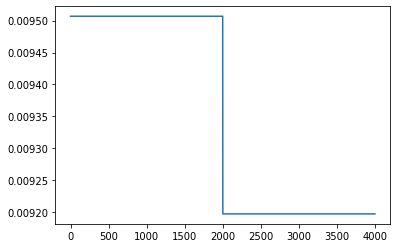

In [212]:
names=['index', 'K_0', 'T', 
       'zm_AD', 'zsigma_AD', 
       'im_AD', 'isigma_AD', 
       'rm_AD', 'rsigma_AD', 
       'gm_AD', 'gsigma_AD', 
       'Km_AD', 'Ksigma_AD', 
       'Hm_AD', 'Hsigma_AD', 
       'Jm_AD', 'Jsigma_AD', 
       'm_DT', 'sigma_DT', 'ℓ','η']

#stepsize should be similar
plt.plot(tracetransfer['step_size_bar'])

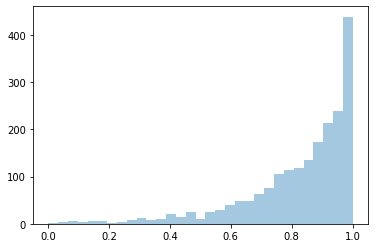

In [213]:
import seaborn as sb
accept = tracetransfer.get_sampler_stats('mean_tree_accept', burn=1000)
sb.distplot(accept, kde=False)

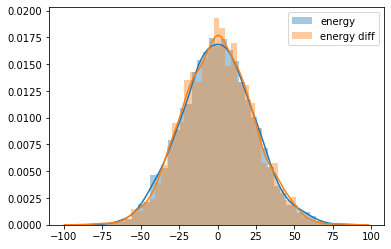

In [214]:
#energy plot should be similar 
energy = tracetransfer['energy']
energy_diff = np.diff(energy)
sb.distplot(energy - energy.mean(), label='energy')
sb.distplot(energy_diff, label='energy diff')
plt.legend()

KeyboardInterrupt: 

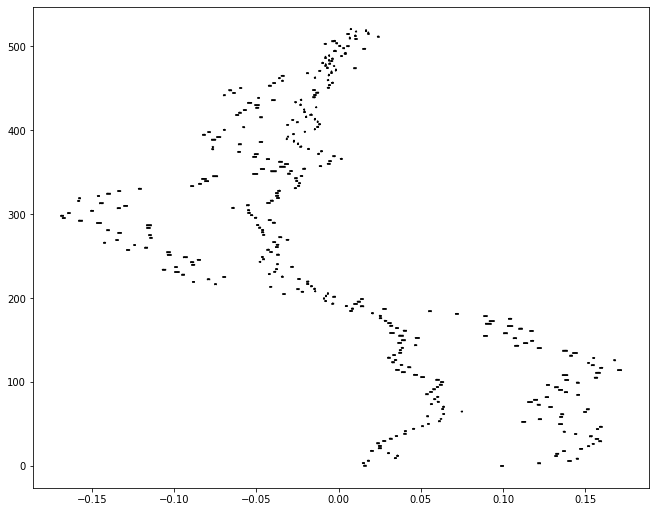

In [205]:
#plot of all the GP variables
pm.plot_forest(tracetransfer,
               kind='ridgeplot',
               var_names=['f'],
               combined=False,
               ridgeplot_overlap=3,
               ridgeplot_alpha=.25,
               colors='white',
               figsize=(9, 7));

In [215]:
pm.summary(tracetransfer,names)#.round(2)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
index     -0.098  0.385  -0.833    0.552      0.014    0.010     762.0   
K_0       -0.806  0.723  -1.921    0.673      0.027    0.019     729.0   
T         -0.141  0.080  -0.272    0.027      0.002    0.002    1323.0   
zm_AD     -0.071  0.387  -0.791    0.654      0.016    0.011     590.0   
zsigma_AD  0.518  0.252   0.063    0.996      0.006    0.004    1873.0   
im_AD     -0.491  0.346  -1.147    0.156      0.011    0.008     979.0   
isigma_AD  0.514  0.311  -0.087    1.067      0.008    0.006    1593.0   
rm_AD     -0.347  0.332  -0.968    0.276      0.008    0.005    1880.0   
rsigma_AD  0.500  0.323  -0.107    1.087      0.008    0.005    1800.0   
gm_AD     -0.886  0.304  -1.445   -0.292      0.007    0.005    2155.0   
gsigma_AD -0.011  0.383  -0.672    0.716      0.010    0.007    1393.0   
Km_AD      0.774  0.480  -0.140    1.691      0.015    0.011     987.0   
Ksigma_AD  0.360  0.371  -0.334    1.038      0.014    0.010     703.0   
Hm_AD      0.456  0.358  -0.228    1.123      0.012    0.009     845.0   
Hsigma_AD  0.163  0.316  -0.405    0.730      0.012    0.009     688.0   
Jm_AD      0.102  0.292  -0.438    0.618      0.013    0.009     543.0   
Jsigma_AD -0.037  0.154  -0.315    0.248      0.004    0.003    1262.0   
m_DT       0.664  0.310   0.128    1.387      0.008    0.005    1657.0   
sigma_DT  -0.182  0.339  -0.651    0.515      0.017    0.012     396.0   
ℓ          3.270  4.030  -4.021   11.108      0.061    0.053    4324.0   
η          0.688  0.528  -0.365    1.565      0.017    0.012     948.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
index       762.0     751.0    1626.0    1.0  
K_0         729.0     836.0    1513.0    1.0  
T           996.0    1819.0    1215.0    1.0  
zm_AD       590.0     601.0    1164.0    1.0  
zsigma_AD  1873.0    1885.0    2497.0    1.0  
im_AD       979.0    1008.0    1505.0    1.0  
isigma_AD  1593.0    1584.0    2246.0    1.0  
rm_AD      1880.0    1934.0    2013.0    1.0  
rsigma_AD  1800.0    1785.0    2358.0    1.0  
gm_AD      2155.0    2301.0    1988.0    1.0  
gsigma_AD  1393.0    1419.0    2071.0    1.0  
Km_AD       987.0    1000.0    1998.0    1.0  
Ksigma_AD   703.0     669.0    1332.0    1.0  
Hm_AD       845.0     847.0    2019.0    1.0  
Hsigma_AD   688.0     636.0    1199.0    1.0  
Jm_AD       543.0     547.0    1175.0    1.0  
Jsigma_AD  1262.0    1250.0    2337.0    1.0  
m_DT       1657.0    1946.0     989.0    1.0  
sigma_DT    396.0     500.0     739.0    1.0  
ℓ          2928.0    4303.0    2806.0    1.0  
η           948.0    1128.0    1740.0    1.0

/home/malte/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/malte/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/malte/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/malte/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "

/home/malte/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/malte/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/malte/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/malte/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "

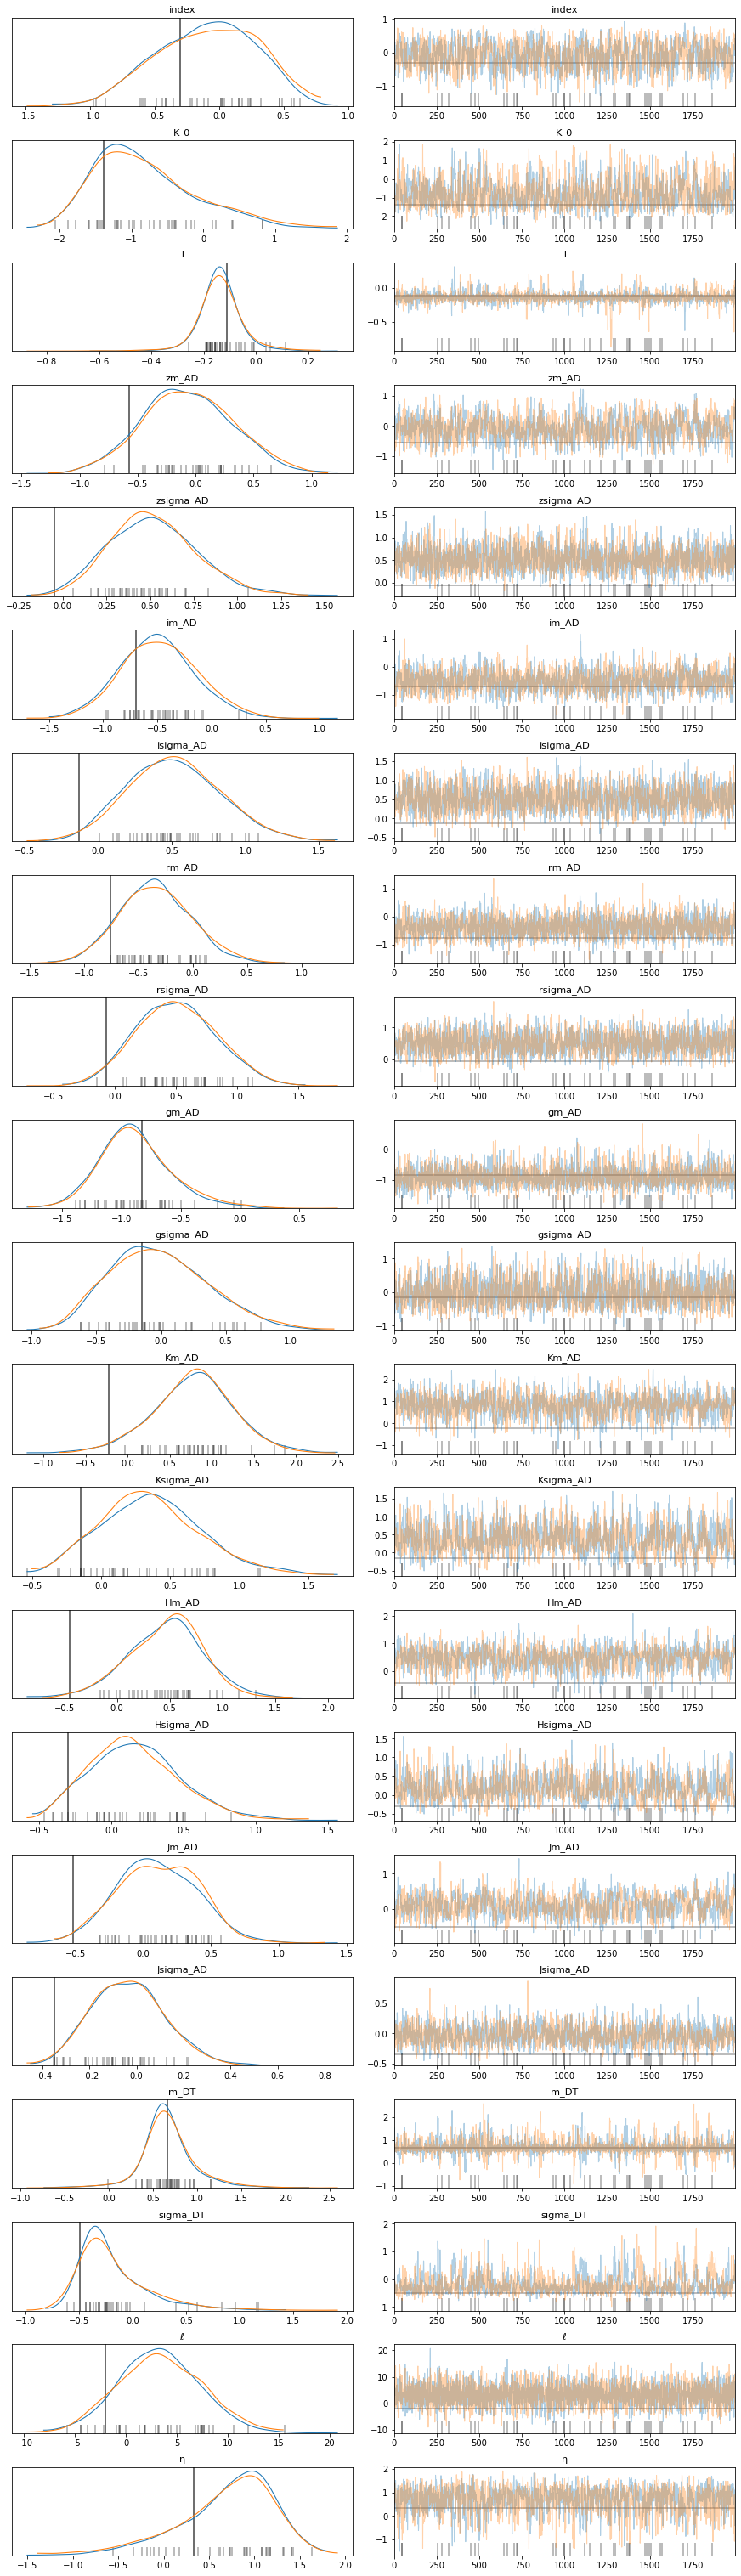

In [238]:
lines = [
    ("index", {}, 1.2-1.5),
    ("K_0", {}, np.log(0.25)),
    ("T", {}, np.log(1356.0)-7.32420984045),
    ("zm_AD", {}, np.log(13.85)-mmuV),
    ("zsigma_AD", {}, 1.2-sigmu),
    ("im_AD", {}, np.log(12.23)-mmuV),
    ("isigma_AD", {}, 1.12-sigmu),
    ("rm_AD", {}, np.log(11.54)-mmuV),
    ("rsigma_AD", {}, 1.18-sigmu),
    ("gm_AD", {}, np.log(10.68)-mmuV),
    ("gsigma_AD", {}, 1.1-sigmu),
    ("Km_AD", {}, np.log(19.66)-mmuV),
    ("Ksigma_AD", {}, 1.1-sigmu),
    ("Hm_AD", {}, np.log(15.61)-mmuV),
    ("Hsigma_AD", {}, 0.95-sigmu),
    ("Jm_AD", {}, np.log(14.62)-mmuV),
    ("Jsigma_AD", {}, 0.9-sigmu),
    ("m_DT", {}, np.log(47.5)-mmu),
    ("sigma_DT", {}, 0.76-sigmu),
    ("ℓ", {}, 13.0-15.0),
    ("η",  {}, np.log(0.1)+2.6374252677060595),
]

pm.traceplot(tracetransfer,lines=lines, var_names=names);

In [239]:
0.9-sigmu

-0.35

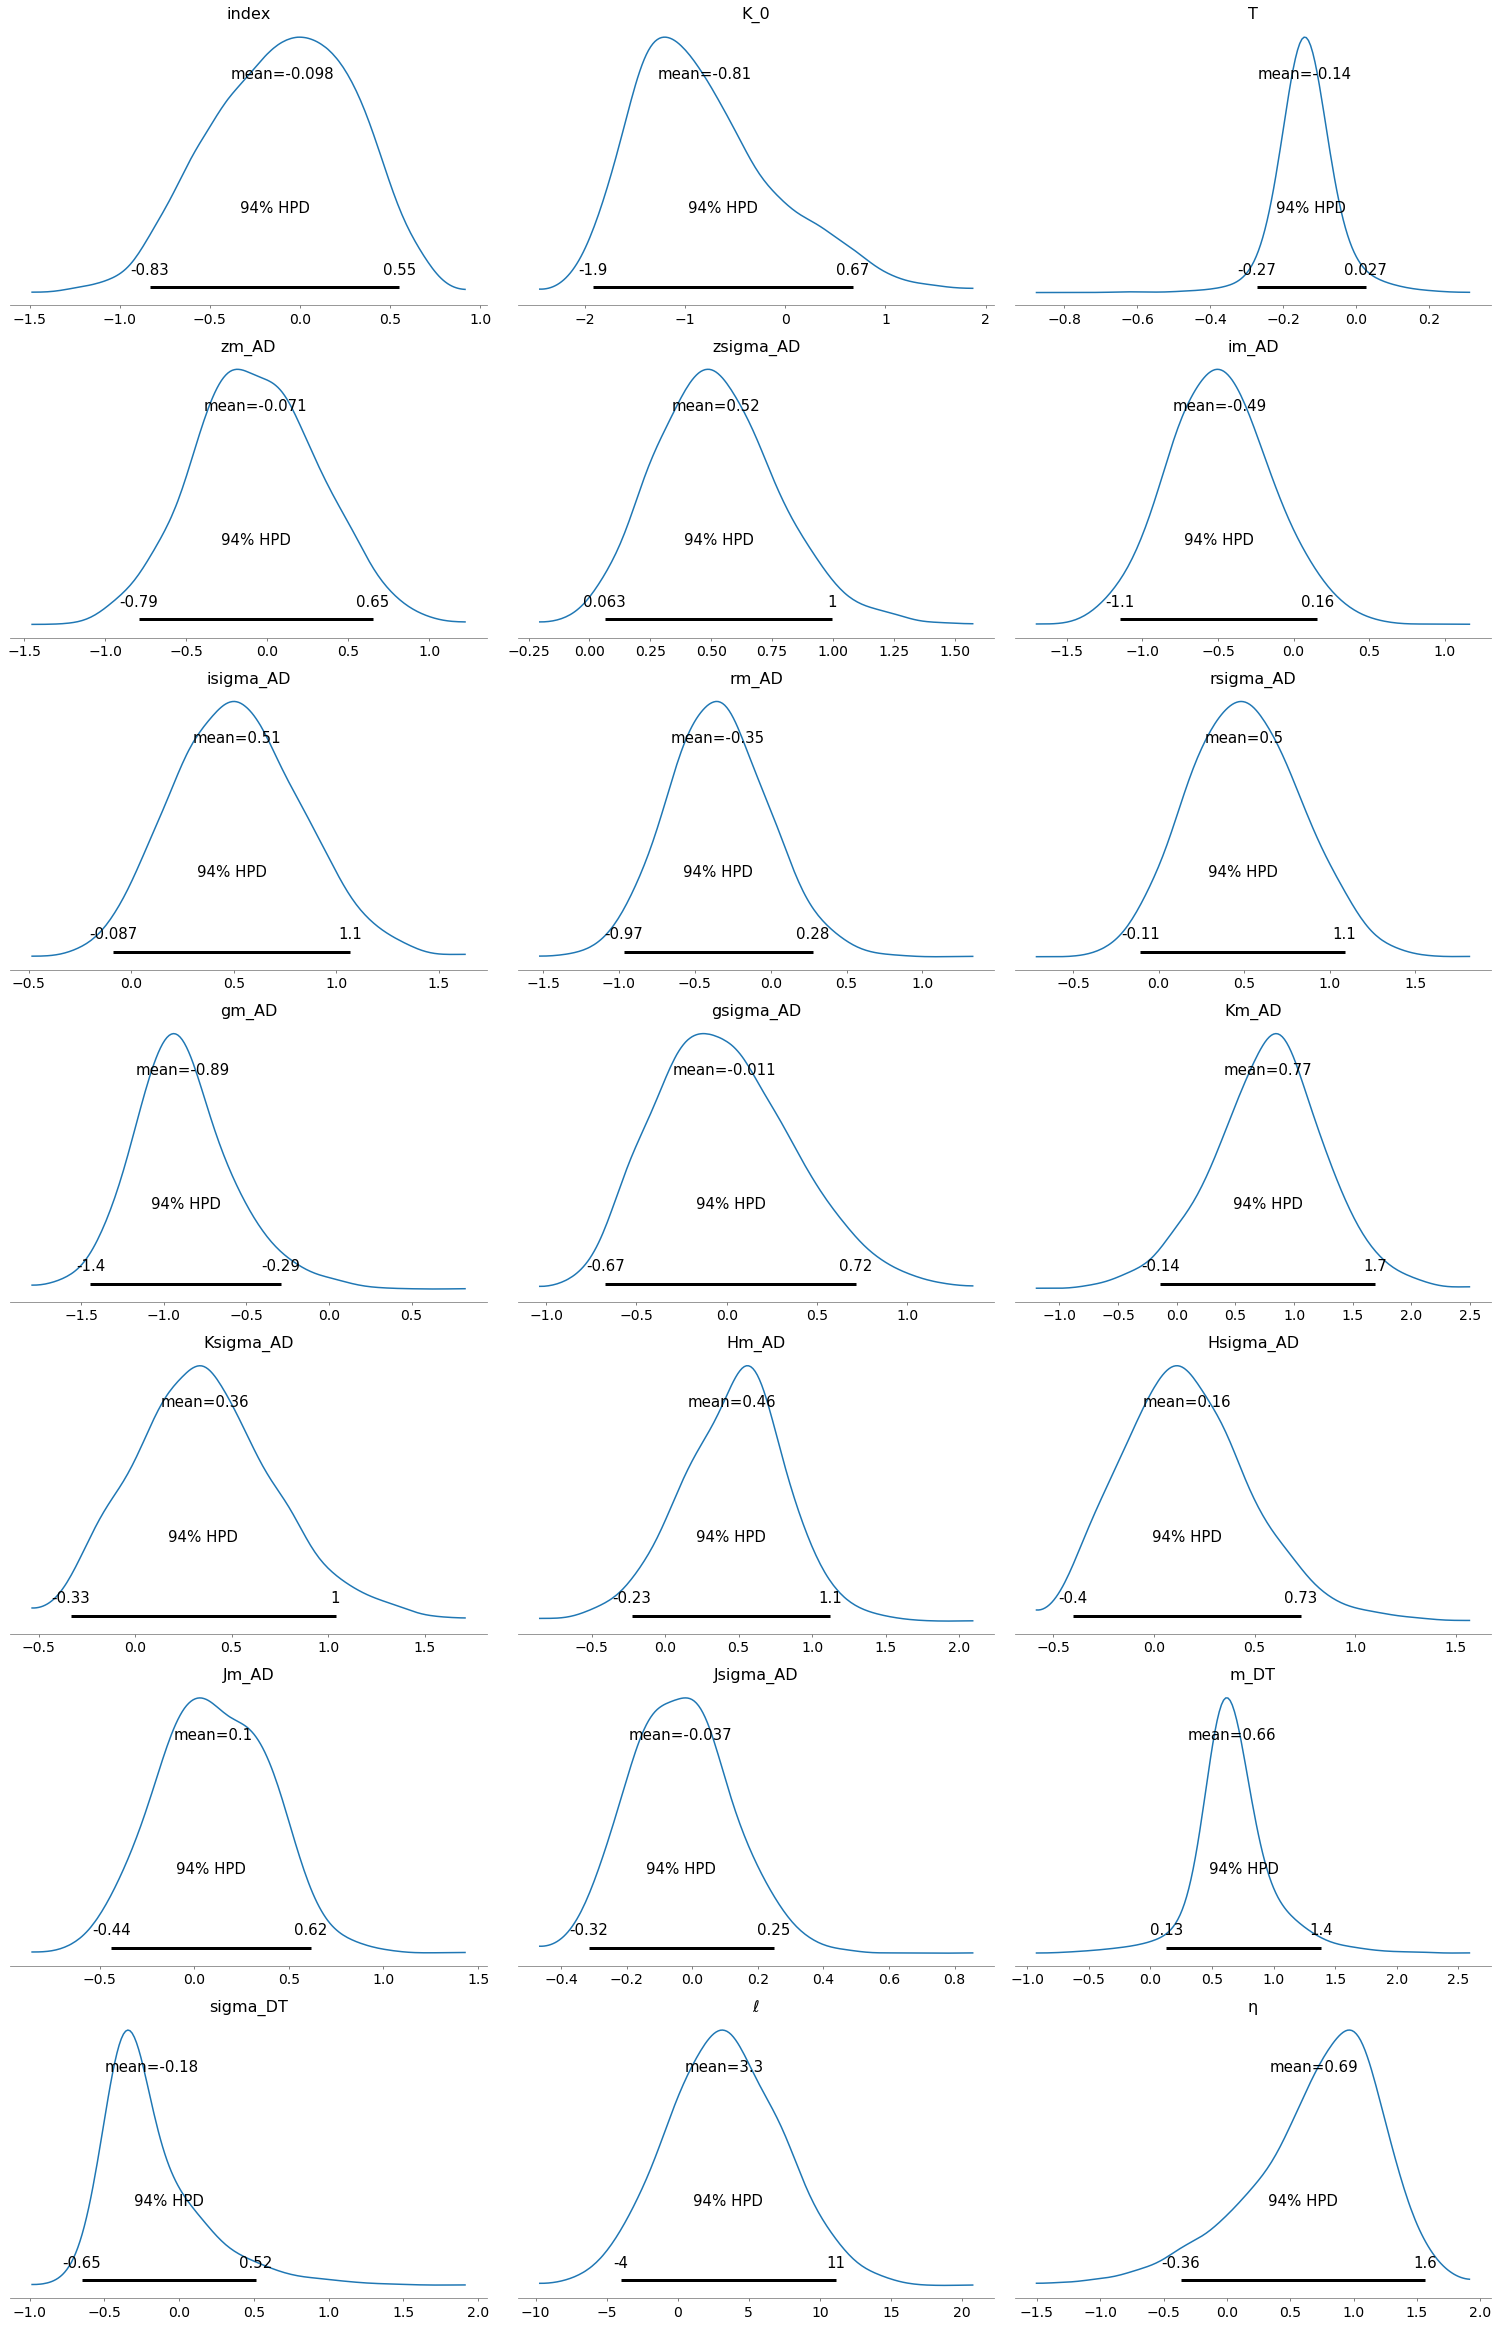

In [234]:
pm.plot_posterior(tracetransfer,var_names=names);

/home/malte/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/pairplot.py:90: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 9x9 grid
  SyntaxWarning,


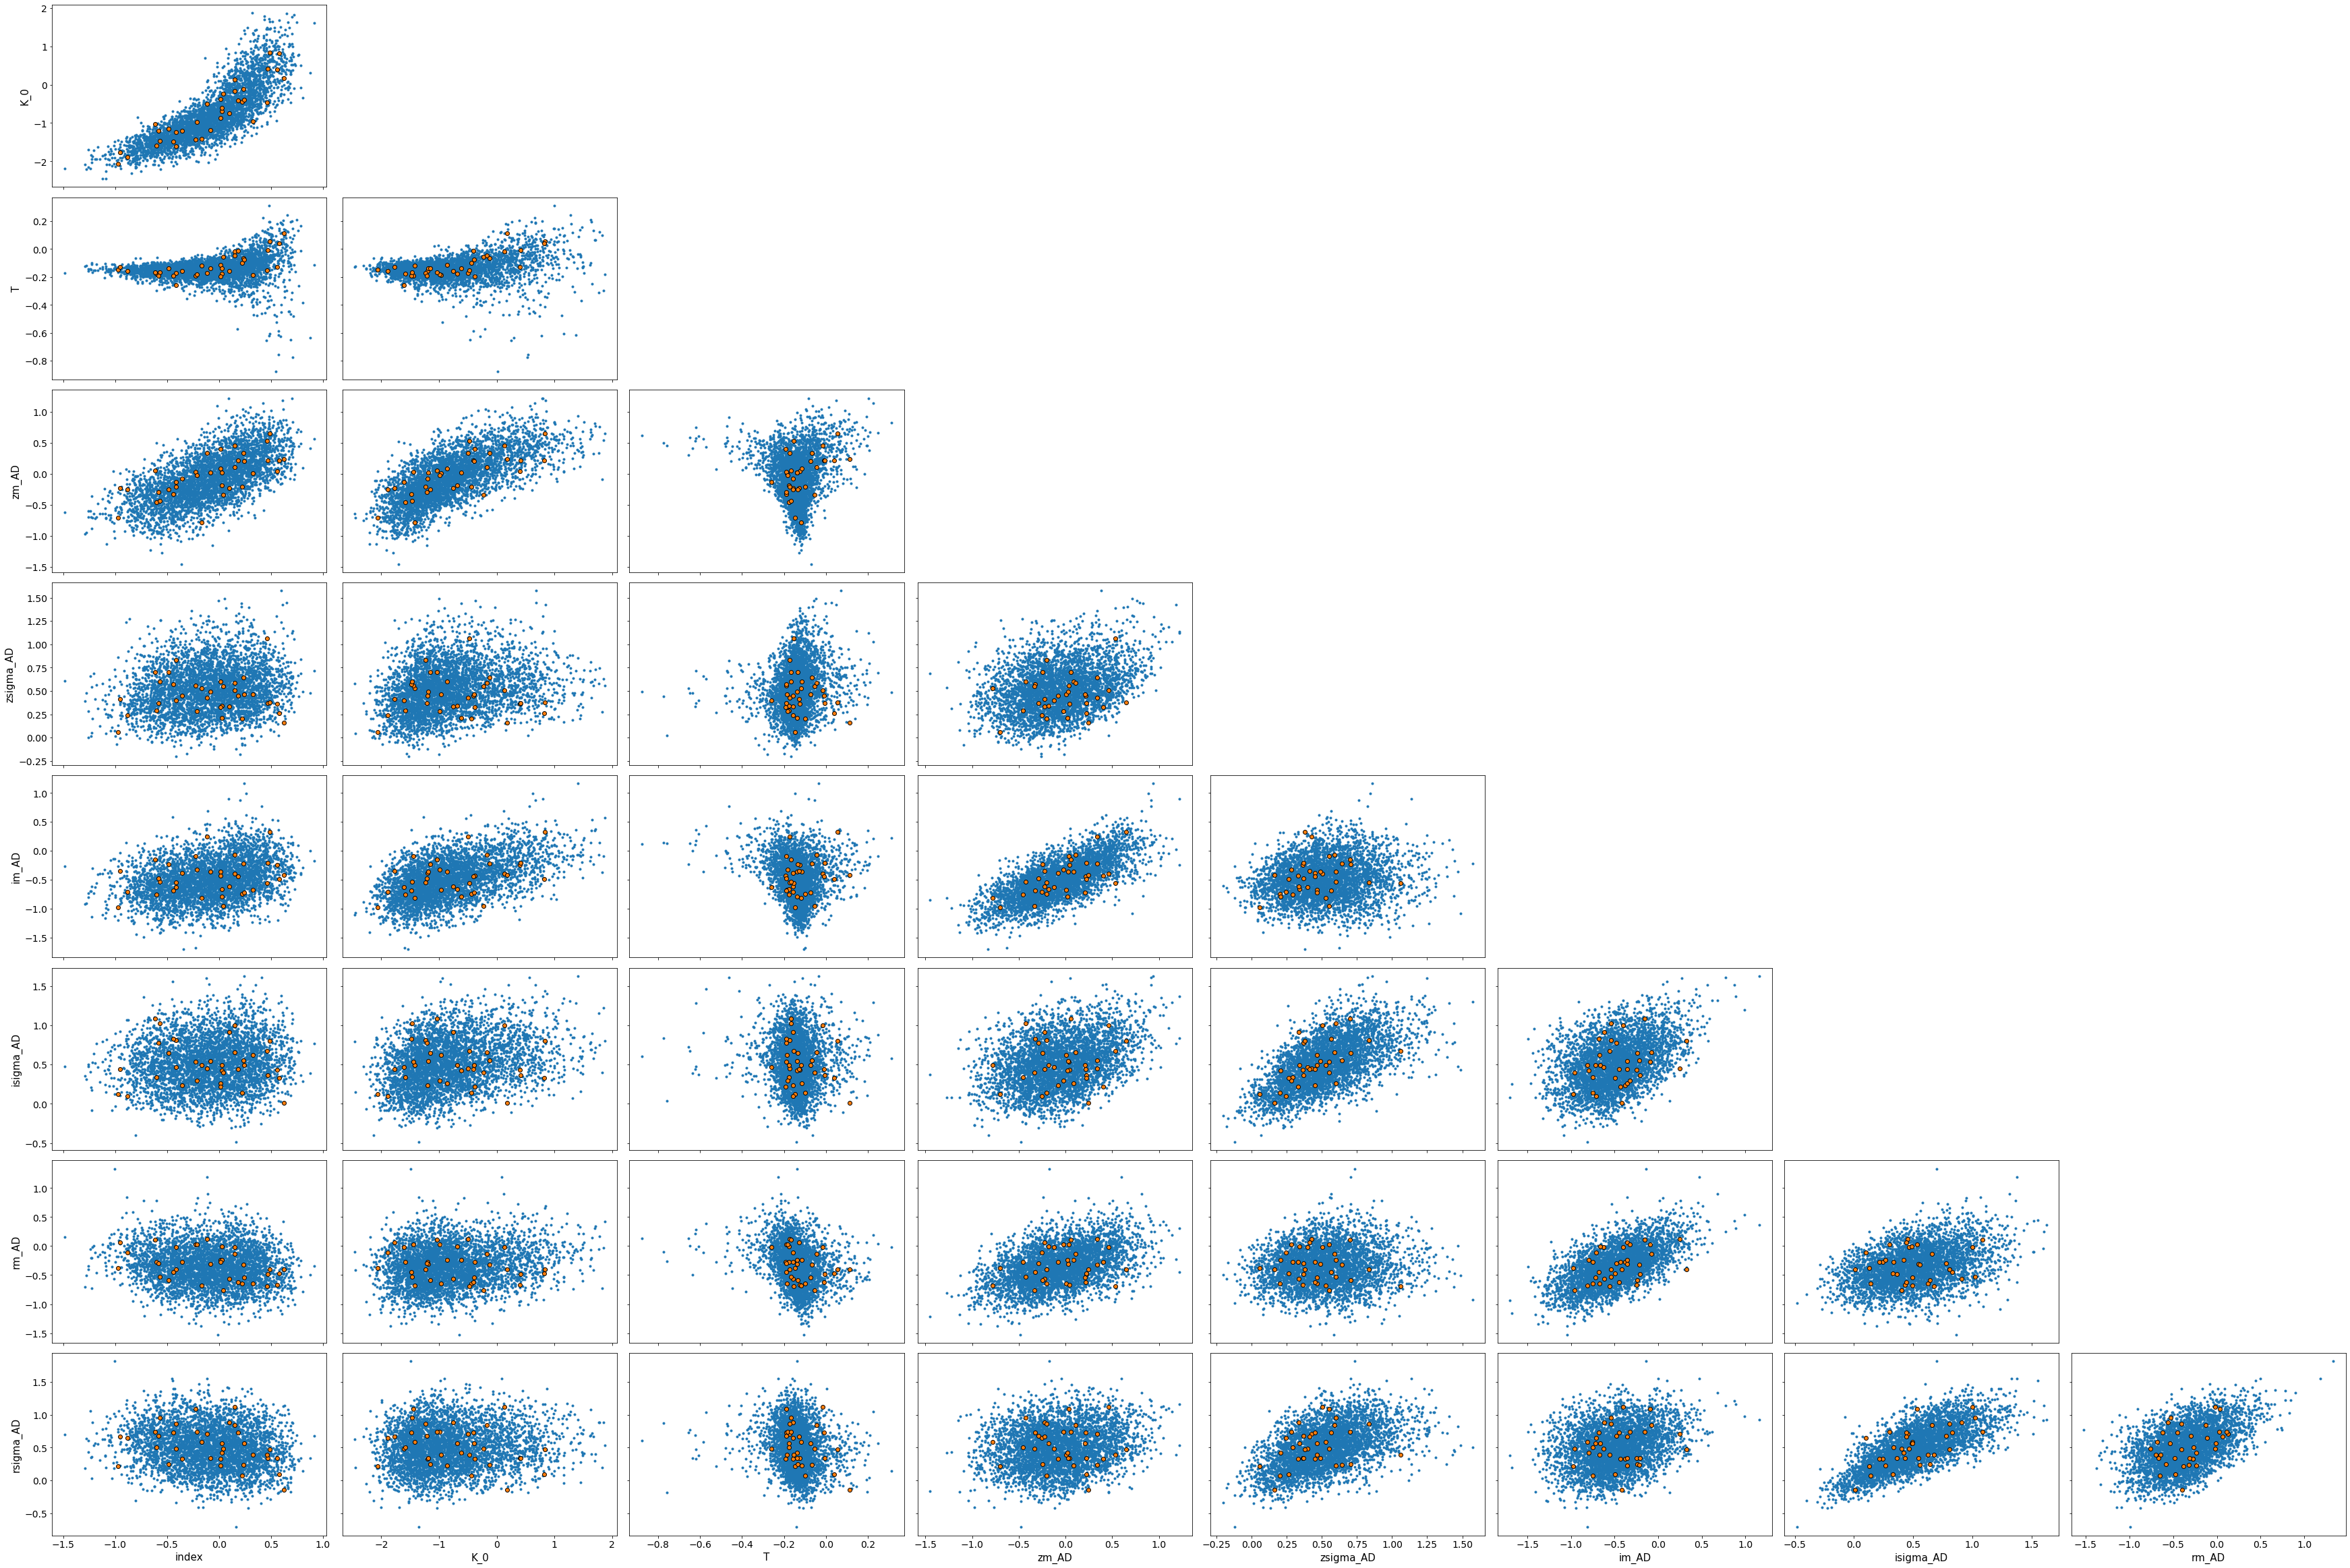

In [221]:
pm.pairplot(tracetransfer, var_names=names, divergences=True);

# Comparison with input data

In [1]:
J_plot=pm.summary(tracetransfer,'J_save').loc[:,'mean']
Jerr_plot=pm.summary(tracetransfer,'J_save').loc[:,'sd']

H_plot=pm.summary(tracetransfer,'H_save').loc[:,'mean']
Herr_plot=pm.summary(tracetransfer,'H_save').loc[:,'sd']

K_plot=pm.summary(tracetransfer,'K_save').loc[:,'mean']
Kerr_plot=pm.summary(tracetransfer,'K_save').loc[:,'sd']

g_plot=pm.summary(tracetransfer,'g_save').loc[:,'mean']
gerr_plot=pm.summary(tracetransfer,'g_save').loc[:,'sd']

r_plot=pm.summary(tracetransfer,'r_save').loc[:,'mean']
rerr_plot=pm.summary(tracetransfer,'r_save').loc[:,'sd']

i_plot=pm.summary(tracetransfer,'i_save').loc[:,'mean']
ierr_plot=pm.summary(tracetransfer,'i_save').loc[:,'sd']

z_plot=pm.summary(tracetransfer,'z_save').loc[:,'mean']
zerr_plot=pm.summary(tracetransfer,'z_save').loc[:,'sd']

NameError: name 'pm' is not defined

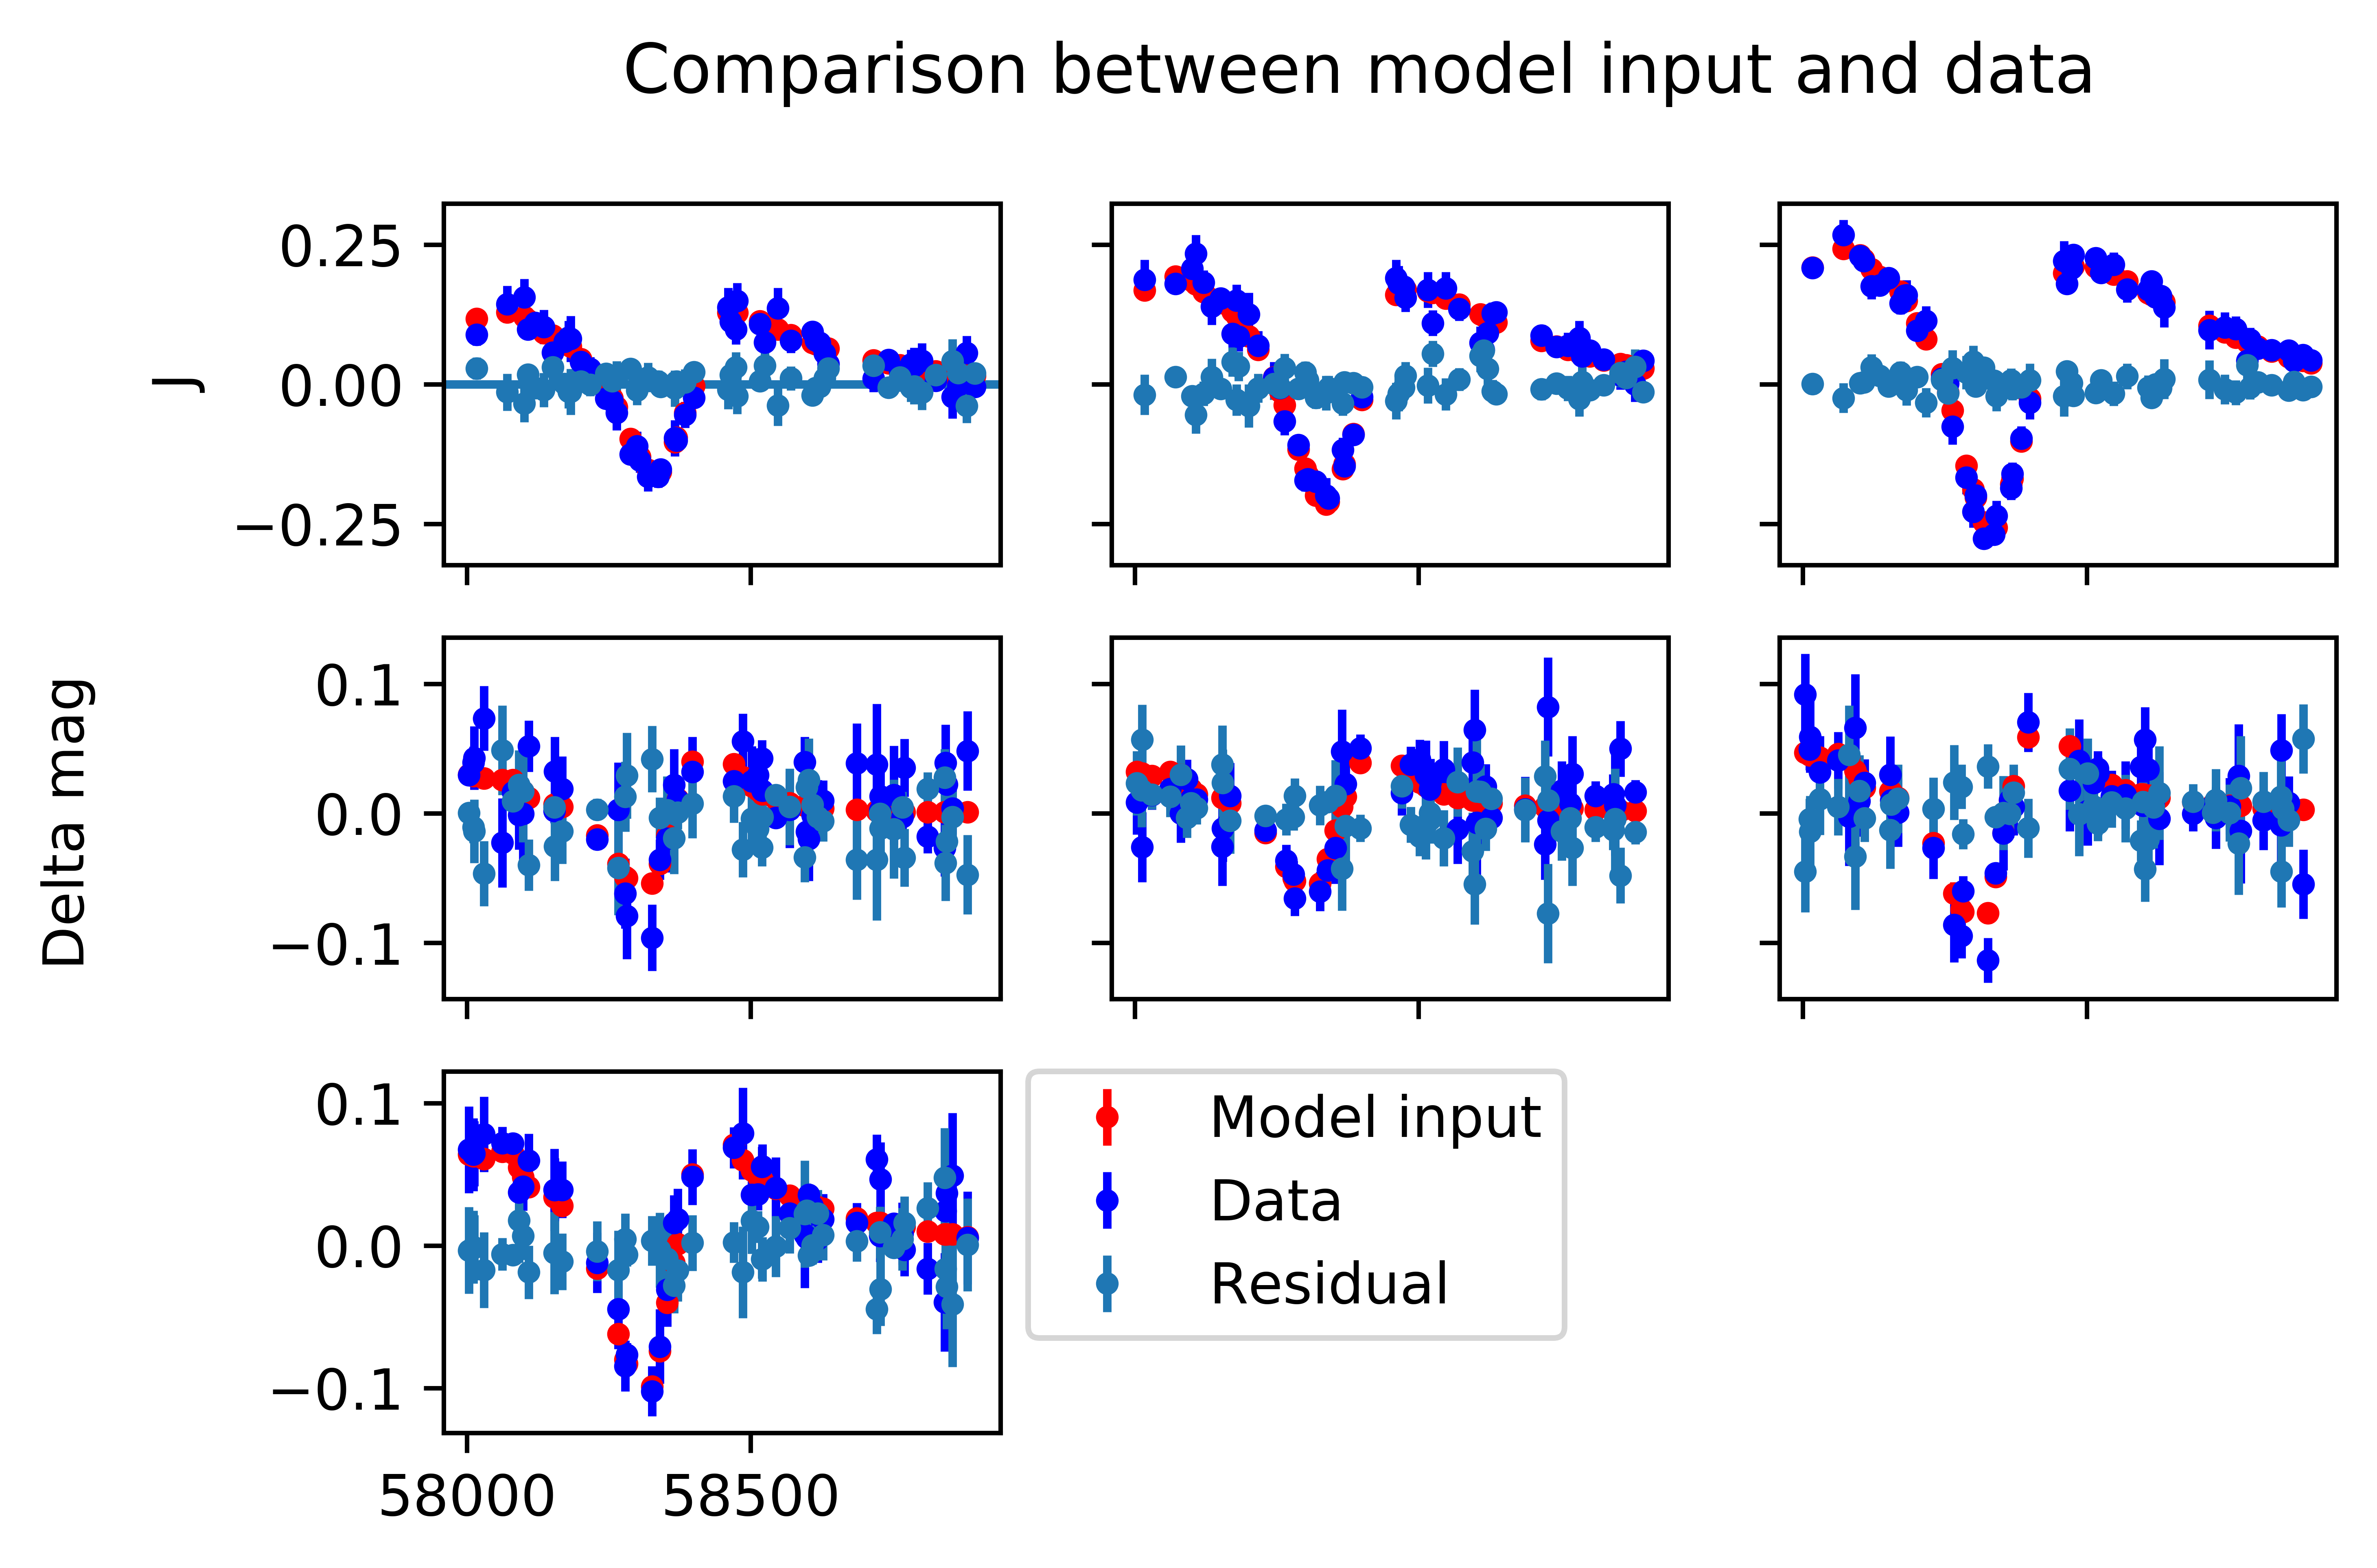

In [283]:
resy=J_plot-yJ

fig, axs = plt.subplots(3,3,dpi=1000,sharex='col',sharey='row')
fig.delaxes(axs[2,2])
fig.delaxes(axs[2,1])
#fig, axs = plt.subplots(2, 3, sharex='col', sharey='row')
fig.suptitle('Comparison between model input and data')
fig.text(-0.04, 0.5, 'Delta mag', va='center', rotation='vertical')

#plt.axhline(y=0.0)

axs[0,0].errorbar(XJ, J_plot, Jerr_plot, fmt='r.', label='J_compare')
axs[0,0].errorbar(XJ, yJ, yJerr, fmt='b.', label='J_data')
axs[0,0].errorbar(XJ,resy,yJerr,fmt='.',label='J residual')
axs[0,0].axhline(y=0.0)
axs[0,0].set(ylabel='J')

axs[0,1].errorbar(XH, H_plot, Herr_plot, fmt='r.', label='H_compare')
axs[0,1].errorbar(XH, yH, yHerr, fmt='b.', label='H_data')
axs[0,1].errorbar(XH,H_plot-yH,yHerr,fmt='.',label='H residual')

axs[0,2].errorbar(XK, K_plot, Kerr_plot, fmt='r.', label='K_compare')
axs[0,2].errorbar(XK, yK, yKerr, fmt='b.', label='K_data')
axs[0,2].errorbar(XK,K_plot-yK,yKerr,fmt='.',label='K residual')

axs[1,0].errorbar(Xg, g_plot, gerr_plot, fmt='r.', label='g_compare')
axs[1,0].errorbar(Xg, yg, ygerr, fmt='b.', label='g_data')
axs[1,0].errorbar(Xg,g_plot-yg,ygerr,fmt='.',label='g residual')

axs[1,1].errorbar(Xr, r_plot, rerr_plot, fmt='r.', label='r_compare')
axs[1,1].errorbar(Xr, yr, yrerr, fmt='b.', label='r_data')
axs[1,1].errorbar(Xr,r_plot-yr,yrerr,fmt='.',label='r residual')

axs[1,2].errorbar(Xi, i_plot, ierr_plot, fmt='r.', label='i_compare')
axs[1,2].errorbar(Xi, yi, yierr, fmt='b.', label='i_data')
axs[1,2].errorbar(Xi,i_plot-yi,yierr,fmt='.',label='i residual')

axs[2,0].errorbar(Xz, z_plot, zerr_plot, fmt='r.', label='Model input')
axs[2,0].errorbar(Xz, yz, yzerr, fmt='b.', label='Data')
axs[2,0].errorbar(Xz,z_plot-yz,yzerr,fmt='.',label='Residual')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

for axs in fig.get_axes():
    axs.label_outer()

#plt.title('Comparison between input data and model data')
#plt.xlabel('Time [d]')
#plt.ylabel('Delta mag')
# fully use the given bounding box.


In [247]:
import scipy
ChiJ=np.sum(((yJ-J_plot)/yJerr)**2)/(len(yJ)-1-9)#scipy.stats.chisquare(yJ,f_exp=J_plot)
ChiH=np.sum(((yH-H_plot)/yHerr)**2)/(len(yH)-1-9)
ChiK=np.sum(((yK-K_plot)/yKerr)**2)/(len(yK)-1-9)
Chig=np.sum(((yg-g_plot)/ygerr)**2)/(len(yg)-1-9)
Chir=np.sum(((yr-r_plot)/yrerr)**2)/(len(yr)-1-9)
Chii=np.sum(((yi-i_plot)/yierr)**2)/(len(yi)-1-9)
Chiz=np.sum(((yz-z_plot)/yzerr)**2)/(len(yz)-1-9)
print([ChiJ,ChiH,ChiK,Chig,Chir,Chii,Chiz])

[0.9750169295952957, 1.2303866771946876, 0.7900445160206883, 1.3322471362887767, 1.2488564317902422, 0.8761699069328583, 0.8466286710933045]


# Transfer function

In [235]:
 def transferDT(wav, pDT, tau):
    sigma_DT, m_DT, theta_DT, T = pDT

    h = 6.626e-34#Plancks constant in units of [m^2*kg/s]
    c = 299792458.0#speed of light in units of [m/s]
    k = 1.38e-23#Boltzmanns constant in units of [m^2*kg/s^2*K]
    wav_0 = 1122.4#Reference wavelength in nm, use 500?
    
    #peak Black Body from uniform torus temperature
    wav_peak = 2.898*10**(-3)/T
    b_max = 4.967#h*c/(1e-9*wav_peak*k*T)
    BB_max = 1.0/( (wav_peak**5) * (np.exp(b_max) - 1.0) )
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((np.log((tau-theta_DT)/m_DT))**2/(2*sigma_DT**2)) 
    front_DT = 1.0/((tau-theta_DT)*sigma_DT*np.sqrt(2*np.pi))
    lognorm_DT = front_DT*np.exp(exp_DT)
    where_are_NaNs1 = np.isnan(lognorm_DT)
    lognorm_DT[where_are_NaNs1] = 0.0
    
    #Dusty Torus transfer equation for band
    b = h*c/(1e-9*wav*k*T)
    BB = (1.0/( ((1e-9*wav)**5 * (np.exp(b) - 1.0) )))/BB_max
    Psi_DT = BB*lognorm_DT
    print(BB)
    return Psi_DT
    
def transferAD(wav, K_0, index, pAD, tau):
    sigma_AD, m_AD, theta_AD = pAD
    
    wav_0 = 1122.4#Reference wavelength in nm, use 500?
    
    #Accretion Disk transfer equation for the band
    powr = K_0*(wav/wav_0)**(index)    
    exp_AD = -((np.log((tau-theta_AD)/m_AD))**2/(2*sigma_AD**2))
    front_AD = 1.0/((tau-theta_AD)*sigma_AD*np.sqrt(2*np.pi))
    lognorm_AD = front_AD*np.exp(exp_AD)
    where_are_NaNs2 = np.isnan(lognorm_AD)
    lognorm_AD[where_are_NaNs2] = 0.0
    Psi_AD = powr*lognorm_AD

    return Psi_AD

pDT = [0.76,47.5,0.0,1356.0]# sigma_DT, m_DT, theta_DT, T
K_0 = 0.25# Power law consant
index = 1.2# Power slope index

    
Jwav = 1250.0 # Wavelength in nm 
JpAD = [0.9,14.62,0.0]# Parameters sigma_AD, m_AD, theta_AD

    
Hwav = 1625.0
HpAD = [0.95,15.61,0.0]

    
Kwav = 2150.0
KpAD = [1.1,19.66,0.0]

    
gwav = 475.4
gpAD = [1.1,10.68,00.0]

    
rwav = 620.4
rpAD = [1.18,11.54,0.0]

    
iwav = 769.8
ipAD = [1.12,12.23,0.0]

    
zwav = 966.5
zpAD = [1.2,13.85,0.0]


#Full transfer equations
Jtransfer = transferDT(Jwav, pDT, tau)+transferAD(Jwav, K_0, index, JpAD, tau)
Htransfer = transferDT(Hwav, pDT, tau)+transferAD(Hwav, K_0, index, HpAD, tau)
Ktransfer = transferDT(Kwav, pDT, tau)+transferAD(Kwav, K_0, index, KpAD, tau)
gtransfer = transferDT(gwav, pDT, tau)+transferAD(gwav, K_0, index, gpAD, tau)
rtransfer = transferDT(rwav, pDT, tau)+transferAD(rwav, K_0, index, rpAD, tau)
itransfer = transferDT(iwav, pDT, tau)+transferAD(iwav, K_0, index, ipAD, tau)
ztransfer = transferDT(zwav, pDT, tau)+transferAD(zwav, K_0, index, zpAD, tau)

0.4272636429616101
0.8177722422287037
0.9999188639100333
5.254509562593178e-05
0.0025642704756717026
0.024132965635651486
0.12803403226165103


In [236]:
J_transfer_plot=pm.summary(tracetransfer,'Jtransfer_save').loc[:,'mean']
J_transfer_err=pm.summary(tracetransfer,'Jtransfer_save').loc[:,'sd']

H_transfer_plot=pm.summary(tracetransfer,'Htransfer_save').loc[:,'mean']
H_transfer_err=pm.summary(tracetransfer,'Htransfer_save').loc[:,'sd']

K_transfer_plot=pm.summary(tracetransfer,'Ktransfer_save').loc[:,'mean']
K_transfer_err=pm.summary(tracetransfer,'Ktransfer_save').loc[:,'sd']

g_transfer_plot=pm.summary(tracetransfer,'gtransfer_save').loc[:,'mean']
g_transfer_err=pm.summary(tracetransfer,'gtransfer_save').loc[:,'sd']

r_transfer_plot=pm.summary(tracetransfer,'rtransfer_save').loc[:,'mean']
r_transfer_err=pm.summary(tracetransfer,'rtransfer_save').loc[:,'sd']

i_transfer_plot=pm.summary(tracetransfer,'itransfer_save').loc[:,'mean']
i_transfer_err=pm.summary(tracetransfer,'itransfer_save').loc[:,'sd']

z_transfer_plot=pm.summary(tracetransfer,'ztransfer_save').loc[:,'mean']
z_transfer_err=pm.summary(tracetransfer,'ztransfer_save').loc[:,'sd']

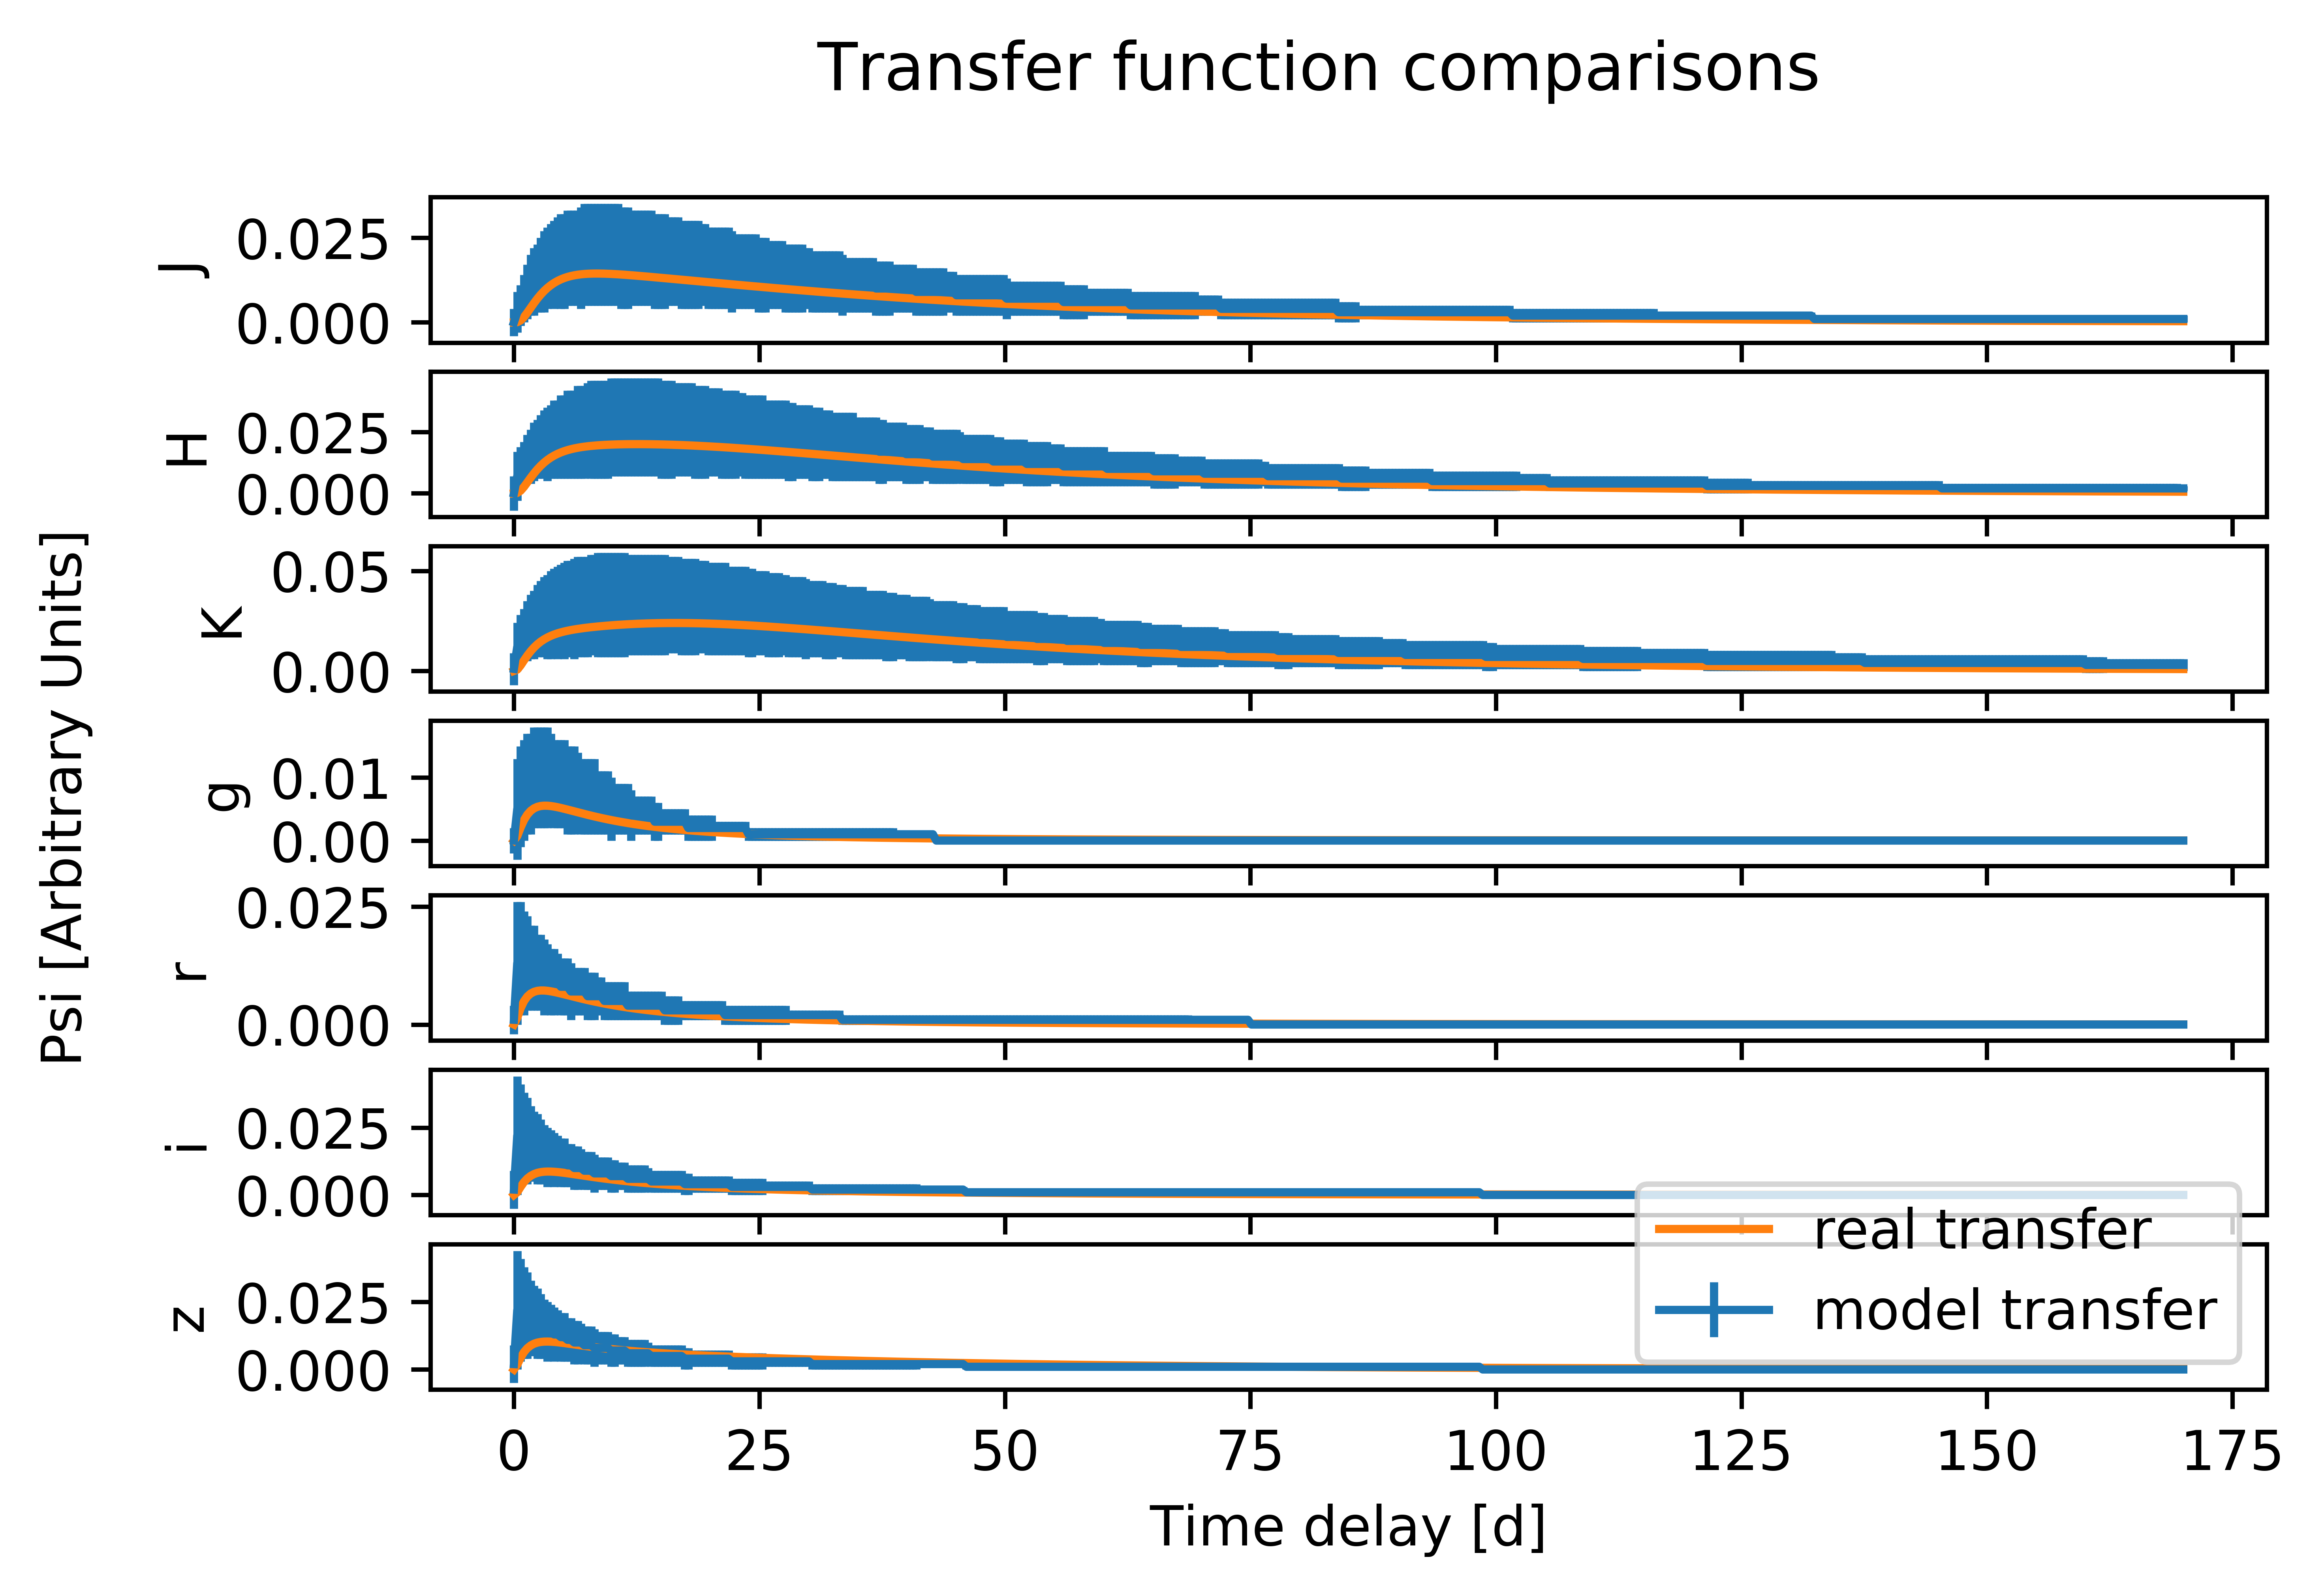

In [252]:
#plt.figure(dpi=1000)

fig, axs = plt.subplots(7,dpi=1000,sharex=True)

fig.suptitle('Transfer function comparisons')
fig.text(-0.04, 0.5, 'Psi [Arbitrary Units]', va='center', rotation='vertical')


axs[0].errorbar(tau, J_transfer_plot, J_transfer_err, label='J_transfer_model')
axs[0].plot(tau,Jtransfer,label='J_transfer')
axs[0].set(ylabel='J')

axs[1].errorbar(tau, H_transfer_plot, H_transfer_err, label='H_transfer_model')
axs[1].plot(tau,Htransfer,label='H_transfer')
axs[1].set(ylabel='H')

axs[2].errorbar(tau, K_transfer_plot, K_transfer_err, label='K_transfer_model')
axs[2].plot(tau,Ktransfer,label='K_transfer')
axs[2].set(ylabel='K')

axs[3].errorbar(tau, g_transfer_plot, g_transfer_err, label='g_transfer_model')
axs[3].plot(tau,gtransfer,label='g_transfer')
axs[3].set(ylabel='g')

axs[4].errorbar(tau, r_transfer_plot, r_transfer_err, label='r_transfer_model')
axs[4].plot(tau,rtransfer,label='r_transfer')
axs[4].set(ylabel='r')

axs[5].errorbar(tau, i_transfer_plot, i_transfer_err, label='i_transfer_model')
axs[5].plot(tau,itransfer,label='i_transfer')
axs[5].set(ylabel='i')

axs[6].errorbar(tau, z_transfer_plot, z_transfer_err, label='model transfer')
axs[6].plot(tau,ztransfer,label='real transfer')
axs[6].set(ylabel='z')

plt.xlabel('Time delay [d]')
plt.legend()

# GP

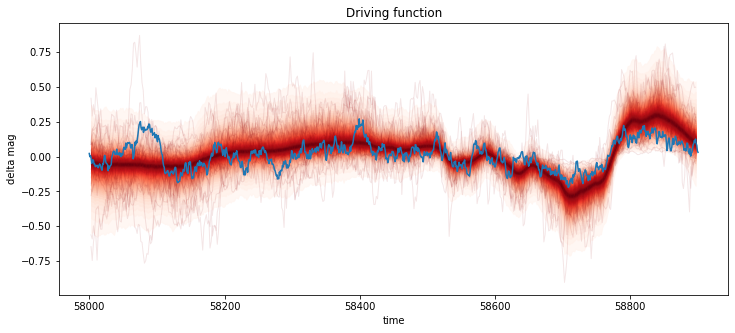

In [218]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, tracetransfer["f"], XGP);
plt.plot(Xdriv,ydriv)
# plot the data and the true latent function
#plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("time"); plt.ylabel("delta mag");
plt.title("Driving function");

In [ ]:
n_new = 1001
X_new = np.linspace(min(X_tot), max(X_tot), n_new)

# add the GP conditional to the model, given the new X values
with convmodel:
    f_tot = gp.conditional("f_tot", X_new)

# Sample from the GP conditional distribution
with convmodel:
    pred_samples = pm.sample_posterior_predictive(tracetransfer, vars=[f_tot], samples=10000)

In [ ]:
# plot the results

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_new"], X_new);
#plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("f(X)");
plt.title("Conditional distribution of f_*, given f");

In [ ]:
#Calculate the mean and standard deviation of the traces. 
mu = np.zeros(len(X_new))
sd = np.zeros(len(X_new))

for i in range(0,len(X_new)):
    mu[i] = np.mean(pred_samples["f_tot"][:,i])
    sd[i] = np.std(pred_samples["f_tot"][:,i])

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 1σ intervals
#plt.plot(X_new, mu, 'r', lw=2, label="mean and 1σ region");
#plt.plot(X_new, mu + 1*sd, 'r', lw=1); plt.plot(X_new, mu - 1*sd, 'r', lw=1);
#plt.fill_between(X_new.flatten(), mu - 1*sd, mu + 1*sd, color="r", alpha=0.5)
plt.errorbar(X_tot,mu,sd,fmt='r.',label='Driving function value at data points')

# plot original data and true function
#plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
#plt.errorbar(X, y, yerr,fmt='.',label="observed data")

plt.xlabel("t");
plt.ylabel("diffmag")
plt.title("predictive mean and 1σ interval"); plt.legend();
print(np.mean(sd))

In [ ]:
plt.errorbar(xJ, yJ, yJerr,fmt='b.',label='J')
plt.errorbar(xH, yH, yHerr,fmt='g.',label='H')
plt.errorbar(xK, yK, yKerr,fmt='r.',label='K')
plt.errorbar(X_tot,mu,sd,fmt='k.',label='Driving')
plt.legend()

# Specify simple model to save time 

In [5]:
import random
yK,yKerr = np.loadtxt('Kband.txt', delimiter=',', usecols=(0,1), unpack=True)
yi,yierr = np.loadtxt('iband.txt', delimiter=',', usecols=(0,1), unpack=True)
yg,ygerr = np.loadtxt('gband.txt', delimiter=',', usecols=(0,1), unpack=True)
X=np.linspace(58000,58900,1000)
yKerr=np.ones(len(yKerr))*max(yKerr)
yierr=np.ones(len(yierr))*max(yierr)
n_list = 49# Number of selected points
the_list = list(range(len(X)))
ind = random.sample(the_list, n_list)
ind2 = random.sample(the_list, n_list) 
yK=yK[ind]
yKerr=yKerr[ind]
XK=X[ind]
yi=yi[ind2]
yierr=yierr[ind2]
Xi=X[ind2]

In [6]:
nf = 499 #Number of GP points
Xf = np.linspace(np.min([XK,Xi])-1.0, np.max([XK,Xi])+1.0,nf)
Xf=np.reshape(Xf,(len(Xf),1))
tau=np.linspace(0.0,100.0,nf)#np.linspace(1.0,100.0,nf)

<ErrorbarContainer object of 3 artists>

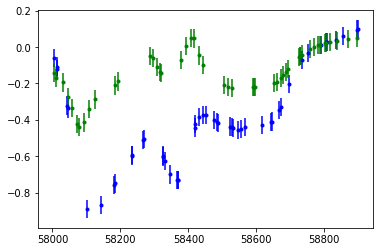

In [7]:
#plt.plot(Xf,2e-6*Xf,'.')
plt.errorbar(XK, yK, yKerr, fmt='b.', label='K')
plt.errorbar(Xi, yi, yierr, fmt='g.', label='i')

In [8]:
mlow=2.3#10
mhigh=3.7#4.1#60
mmu=(mhigh+mlow)/2.0
msig=(mhigh-mlow)/2.0
siglow=0.1
sighigh=2.55
sigmu=(sighigh+siglow)/2.0
sigsig=(sighigh-siglow)/2.0
#Different wavelength for different bands, not a free paramter 
#REMIR filters in nm
#Kwav = 2150.0
#Sloan filters for ROSS2 in nm
#iwav = 769.8
#Define constants 
#wav_0 = 1122.4#Reference wavelength in nm, use 500?
#h = 6.626e-34#Plancks constant in J*s
#c = 299792458.0#speed of light in m/s
#k = 1.38e-23#Boltzmanns constant in J/K

#b_max = 4.967

#theano.compile.mode.Mode(linker='py', optimizer='fast_compile')
#theano.compile.mode.Mode(linker='cvm', optimizer='fast_run')
#theano.THEANO_FLAGS='device=cuda,floatX=float32'
#theano.optimizer_including('cudnn')
#theano.optimizer_including=conv_meta
#dnn.enable=True
#theano.config.lib.amdlibm='True'

In [9]:
ygmean=np.mean(yg)

In [9]:
with pm.Model() as convmodel:
    ############################################
    #define driving function as Gaussian Process
    ############################################
    #find way to use g band as first guess of value 
    ℓ = pm.Normal('ℓ', mu=3.4, sigma=0.4)#timescale of variation for the driving function, order of days for UV
    #REMEMBER time scale is 2*ℓ^2 so remember to rewrite as ℓ_true=2*ℓ^2
    η = pm.Bound(pm.Normal, lower=0.0,upper=0.4)('η', mu=0.2, sigma=0.2)#long term standard deviation for the driving function
    cov = η**2 * pm.gp.cov.Exponential(1, ls=tt.exp(ℓ))#using same cov as light curve interpolation
    #mean_func=pm.gp.mean.Constant(ygmean)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=Xf,reparameterize = False)
    f = f.reshape((1,1,len(Xf),1))
    
    ##############
    #Define priors
    ##############
    #Universal Dusty Torus parameters for the uniform temperature DT
    sigma_DT=pm.Bound(pm.Normal, lower=siglow,upper=sighigh)('sigma_DT', mu=sigmu, sigma=sigsig)#needs a source for scale
    m_DT=pm.Bound(pm.Normal, lower=mlow,upper=mhigh)('m_DT', mu=mmu, sigma=msig)#we expect serveral tens to hundreds of days from the nature letter
    theta_DT=pm.Bound(pm.Normal, lower=2.3,upper=4.1)('theta_DT', mu=3.2,sigma=0.9)#add later when simple model is staple
    #Accretion Disk paramters
    #K band
    Ksigma_AD=pm.Bound(pm.Normal, lower=siglow,upper=sighigh)('Ksigma_AD', mu=sigmu, sigma=sigsig)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    Ktheta_AD=0.0#pm.Normal('Ktheta_AD',mu=0.0,sigma=10.0)#add later 
    Km_AD=pm.Bound(pm.Normal, lower=mlow,upper=mhigh)('Km_AD', mu=mmu, sigma=msig)#AD has 3-5 times smaller lags than DT  
    #i band
    isigma_AD=pm.Bound(pm.Normal, lower=siglow,upper=sighigh)('isigma_AD', mu=sigmu, sigma=sigsig)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    itheta_AD=0.0#pm.Normal('gtheta_AD',mu=0.0,sigma=10.0)#add later 
    im_AD=pm.Bound(pm.Normal, lower=mlow,upper=mhigh)('im_AD', mu=mmu, sigma=msig)#AD has 3-5 times smaller lags than DT 
    #BB and power law parameters
    T=pm.Bound(pm.Normal, lower=6.90775527898 ,upper=7.74066440192)('T',mu=7.32420984045,sigma=0.41645456146)#taken from nature letter
    K_0=pm.Bound(pm.Normal, lower=-2.3,upper=2.3)('K_0', mu=0, sigma=2.3)#powr/BB
    index=pm.Bound(pm.Normal, lower=0.5,upper=3.0)('index', mu=1.5, sigma=0.5)#pm.Uniform('index',lower=0.5,upper=2.5)#pm.TruncatedNormal('index', mu=1.5, sigma=0.5,lower=0.0)#sign depends on diffmag definition change to -2 to -1
    #Note for index: we have taken the transformation from F_nu to F_lamb into account with the index value.
                         

    
    #Peak Black Body from uniform torus temperature
    #wav_peak = 2.898*10**6/tt.exp(T)
    #b_max = 4.967#h*c/(1e-9*wav_peak*k*tt.exp(T))
    BB_max = -79.3575 + 5.0*T#the log of the peak wavelength blackbody#-5*tt.log(wav_peak)-tt.log( (tt.exp(b_max) - 1.0) )
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((tt.log((tau-tt.exp(theta_DT))/tt.exp(m_DT)))**2/(2*sigma_DT**2)) 
    front_DT = 1.0/((tau-tt.exp(theta_DT))*sigma_DT*tt.sqrt(2*np.pi))
    lognorm_DT = front_DT*tt.exp(exp_DT)
    lognorm_DT = tt.switch(tt.isnan(lognorm_DT), 0.0, lognorm_DT)
    

    #Dusty Torus transfer equation for K band
    Kb = 6692.0/tt.exp(T)
    KBB = -38.36611560560854-tt.log(tt.exp(Kb) - 1.0)
    KPsi_DT = (tt.exp(KBB)/tt.exp(BB_max))*lognorm_DT
    #Dusty Torus transfer equation for i band
    ib = 18690.0/tt.exp(T)
    iBB = -33.230653704248226-tt.log(tt.exp(ib) - 1.0)
    iPsi_DT = (tt.exp(iBB)/tt.exp(BB_max))*lognorm_DT   
    

    #Accretion Disk transfer equation for the K band
    Kpowr = K_0+0.649998592333457*index   
    Kexp_AD = -((tt.log((tau-Ktheta_AD)/tt.exp(Km_AD)))**2/(2*Ksigma_AD**2))
    Kfront_AD = 1.0/((tau-Ktheta_AD)*Ksigma_AD*tt.sqrt(2*np.pi))
    Klognorm_AD = Kfront_AD*tt.exp(Kexp_AD)
    Klognorm_AD = tt.switch(tt.isnan(Klognorm_AD), 0.0, Klognorm_AD)
    KPsi_AD = tt.exp(Kpowr)*Klognorm_AD
    #Accretion Disk transfer equation for the i band
    ipowr = K_0-0.3770937879386054*index   
    iexp_AD = -((tt.log((tau-itheta_AD)/tt.exp(im_AD)))**2/(2*isigma_AD**2))
    ifront_AD = 1.0/((tau-itheta_AD)*isigma_AD*tt.sqrt(2*np.pi))
    ilognorm_AD = ifront_AD*tt.exp(iexp_AD)
    ilognorm_AD = tt.switch(tt.isnan(ilognorm_AD), 0.0, ilognorm_AD)
    iPsi_AD = tt.exp(ipowr)*ilognorm_AD
    
    #########################
    #Full transfer equations
    #########################
    
    Ktransfer = KPsi_DT + KPsi_AD
    Ktransfer = Ktransfer.reshape(((1,1,len(tau),1)))
    itransfer = iPsi_DT + iPsi_AD
    itransfer = itransfer.reshape(((1,1,len(tau),1)))

    #The convolutions
    ######################################################################
    #'half': pad input with a symmetric border of filter rows // 2
    #rows and filter columns // 2 columns, then perform a valid convolution. 
    #For filters with an odd number of rows and columns, 
    #this leads to the output shape being equal to the input shape.
    ######################################################################

    Kconvol=theano.tensor.nnet.conv2d(f,Ktransfer,border_mode='half')
    Kcomp=interpolate(Xf[:,0],Kconvol[0,0,:,0],XK)
    #Kcomp = pm.Deterministic('Kcomp', interpolate(Xf[:,0],Kconvol[0,0,:,0],XK))
    iconvol=theano.tensor.nnet.conv2d(f,itransfer,border_mode='half')
    icomp=interpolate(Xf[:,0],iconvol[0,0,:,0],Xi)
    #icomp = pm.Deterministic('icomp', interpolate(Xf[:,0],iconvol[0,0,:,0],Xi))
    #Define likelihoods

    #kK = pm.TruncatedNormal('kK', mu=1.0, sigma=1.0, lower=0.0, upper=3.0)
    #kg = pm.TruncatedNormal('kg', mu=1.0, sigma=1.0, lower=0.0, upper=3.0)

    Klikelihood = pm.Normal('yK', mu=Kcomp, sigma=yKerr, observed=yK)
    ilikelihood = pm.Normal('yi', mu=icomp, sigma=yierr, observed=yi)
    
    #the shape of mu and observed needs to be the same
    ######################################################################
    #max_treedepth, default=10
    #The maximum tree depth. Trajectories are stopped when this depth is reached.
    #early_max_treedepth, default=8
    #The maximum tree depth during the first 200 tuning samples.
    ######################################################################
    
    #tracetransfer = pm.sample(1000,tune=1000,init='adapt_diag',chains=1,cores=8)
    #tracetransfer = pm.sample(10000,tune=5000,chains=2,cores=8,step=pm.Metropolis())
    #map_soln = xo.optimize(start=convmodel.test_point)
    #tracetransfer = pm.sample(draws=2000,tune=2000,chains=4,step=xo.get_dense_nuts_step())
    tracetransfer = pm.sample(2000,tune=2000,init='advi+adapt_diag',chains=2)
    #tracetransfer = pm.sample(2000,tune=2000,init='nuts',n_init=1000)
    #tracetransfer = pm.fit(300, method='svgd', inf_kwargs=dict(n_particles=100))
    #tracetransfer = pm.fit(300,method=pm.SVGD(n_particles=1000, jitter=1.))
    #tracetransfer= pm.fit(20000,method='fullrank_advi',callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')])
    #tracetransfer = pm.find_MAP()
    
    #test model valeus for nan or strange things    
#     # make sure all test_value are finite
#     print(convmodel.test_point)

#     # make sure all logp are finite
#     print(convmodel.check_test_point())
    
#     step = pm.HamiltonianMC()
# q0 = step._logp_dlogp_func.dict_to_array(convmodel.test_point)
# p0 = step.potential.random()
# # make sure the potentials are all finite
# print(p0)
# logp, dlogp = step.integrator._logp_dlogp_func(q0)
# print(logp)
# print(dlogp)

# # make sure velocity is finite
# v = step.integrator._potential.velocity(p0)
# print(v)
# kinetic = step.integrator._potential.energy(p0, velocity=v)
# print(kinetic)
    
#convmodel.profile(convmodel.logpt).summary()
#convmodel.profile(pm.gradient(convmodel.logpt, convmodel.vars)).summary()
#pm.model_to_graphviz(convmodel)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
  0%|          | 0/200000 [00:00<?, ?it/s]/home/malte/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Average Loss = 53.297:  12%|█▏        | 24198/200000 [16:12<1:57:42, 24.89it/s]   
Convergence achieved at 24200
Interrupted at 24,199 [12%]: Average Loss = 10,906
/home/malte/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a differe

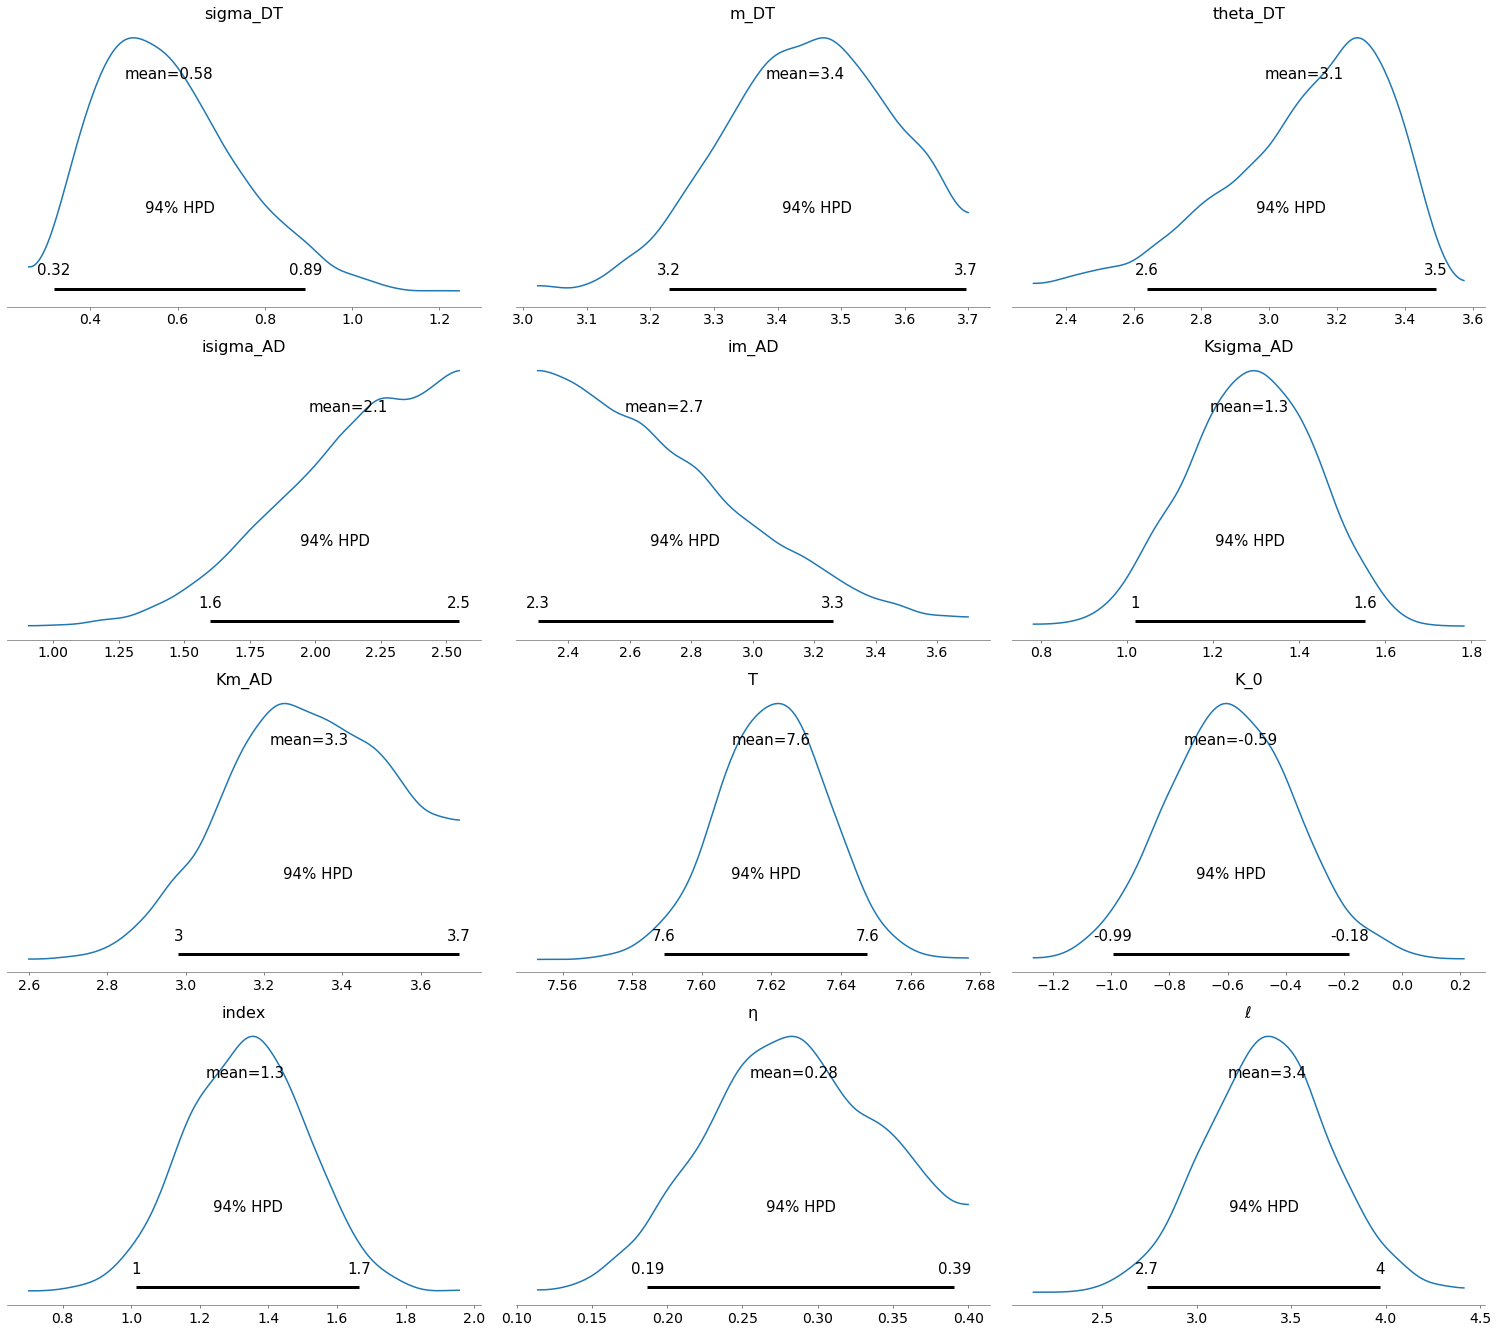

In [10]:
tracesimple=tracetransfer
simplenames=['sigma_DT','m_DT','theta_DT','isigma_AD','itheta_AD','im_AD','Ksigma_AD','Ktheta_AD','Km_AD','T','K_0','index', 'η', 'ℓ']
simplenames=['sigma_DT','m_DT','theta_DT','isigma_AD','im_AD','Ksigma_AD','Km_AD','T','K_0','index', 'η', 'ℓ']
pm.plot_posterior(tracesimple, simplenames);

# Approx results

In [ ]:
resu=tracesimple.sample(5000)
pm.plot_posterior(resu,simplenames);
pm.summary(resu,simplenames)

In [ ]:
pm.traceplot(resu, var_names=simplenames);

In [ ]:
pm.plot_forest(tracesimple,
               kind='ridgeplot',
               var_names=['f'],
               combined=False,
               ridgeplot_overlap=3,
               ridgeplot_alpha=.25,
               colors='white',
               figsize=(9, 7));

# Sampler convergence statistics

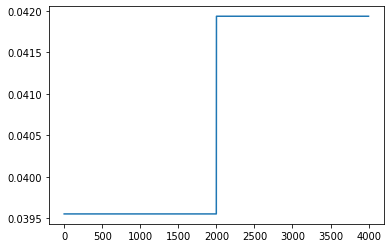

In [11]:
plt.plot(tracesimple['step_size_bar'])

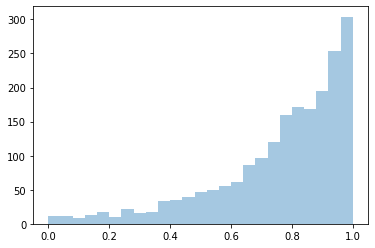

In [12]:
import seaborn as sb
accept = tracesimple.get_sampler_stats('mean_tree_accept', burn=1000)
sb.distplot(accept, kde=False)

In [13]:
tracesimple['diverging'].nonzero()

(array([], dtype=int64),)

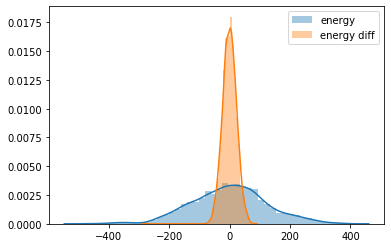

In [14]:
energy = tracesimple['energy']
energy_diff = np.diff(energy)
sb.distplot(energy - energy.mean(), label='energy')
sb.distplot(energy_diff, label='energy diff')
plt.legend()

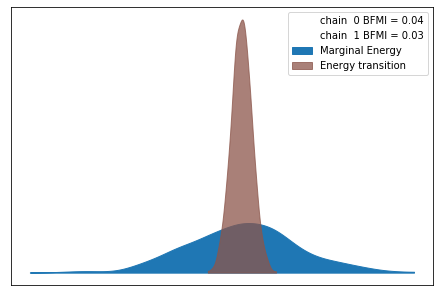

In [15]:
pm.energyplot(tracesimple);

# Sampler results

In [16]:
summ=pm.summary(tracesimple,simplenames)
#print(summ.loc[:,'mean'])
summ

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
sigma_DT   0.581  0.164   0.317    0.893      0.007    0.005     565.0   
m_DT       3.443  0.131   3.230    3.696      0.005    0.003     756.0   
theta_DT   3.103  0.246   2.638    3.490      0.007    0.005    1160.0   
isigma_AD  2.125  0.301   1.599    2.549      0.009    0.007    1059.0   
im_AD      2.711  0.303   2.300    3.260      0.005    0.004    3399.0   
Ksigma_AD  1.284  0.146   1.018    1.554      0.004    0.003    1281.0   
Km_AD      3.314  0.205   2.981    3.697      0.004    0.003    2405.0   
T          7.620  0.016   7.589    7.648      0.000    0.000    2381.0   
K_0       -0.590  0.217  -0.994   -0.182      0.016    0.011     184.0   
index      1.333  0.175   1.015    1.664      0.005    0.003    1303.0   
η          0.284  0.057   0.187    0.391      0.007    0.005      59.0   
ℓ          3.371  0.323   2.735    3.969      0.026    0.019     150.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
sigma_DT    565.0     501.0    1178.0   1.00  
m_DT        756.0     762.0    2270.0   1.01  
theta_DT   1139.0    1073.0    1943.0   1.00  
isigma_AD  1059.0    1108.0    1296.0   1.01  
im_AD      3394.0    3271.0    3042.0   1.00  
Ksigma_AD  1281.0    1281.0    1991.0   1.01  
Km_AD      2404.0    2400.0    2789.0   1.00  
T          2381.0    2378.0    2864.0   1.00  
K_0         184.0     184.0     827.0   1.02  
index      1303.0    1298.0    2942.0   1.00  
η            59.0      52.0      73.0   1.05  
ℓ           150.0     149.0     236.0   1.02

/home/malte/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/malte/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/malte/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/malte/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "

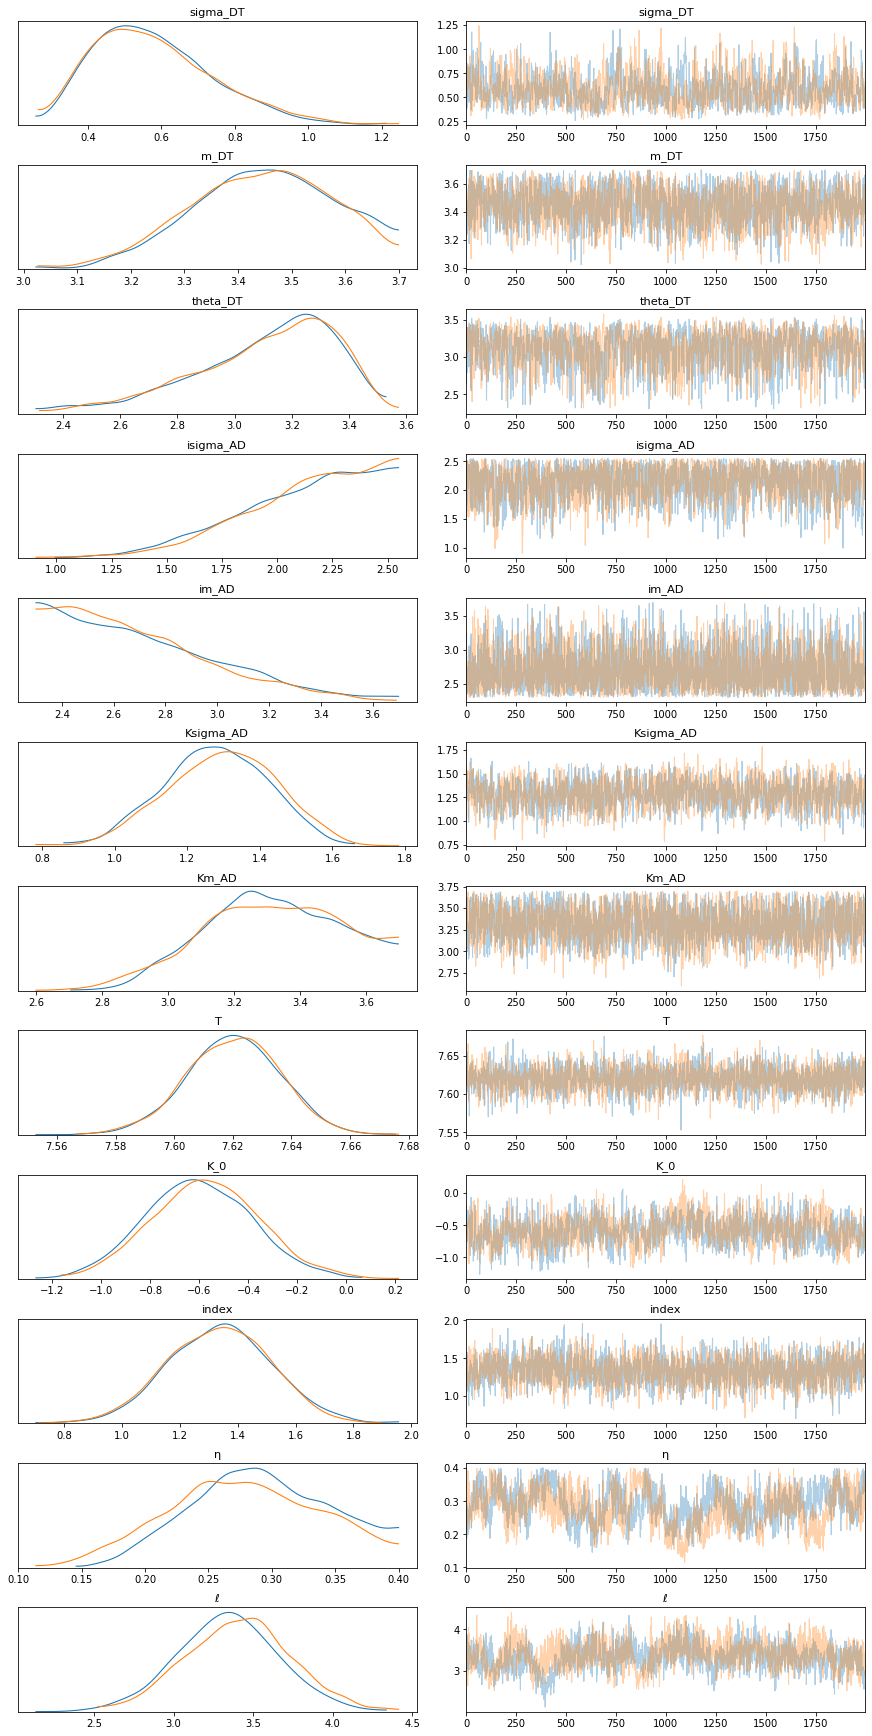

In [17]:
pm.traceplot(tracesimple, var_names=simplenames);

/home/malte/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/pairplot.py:90: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 9x9 grid
  SyntaxWarning,


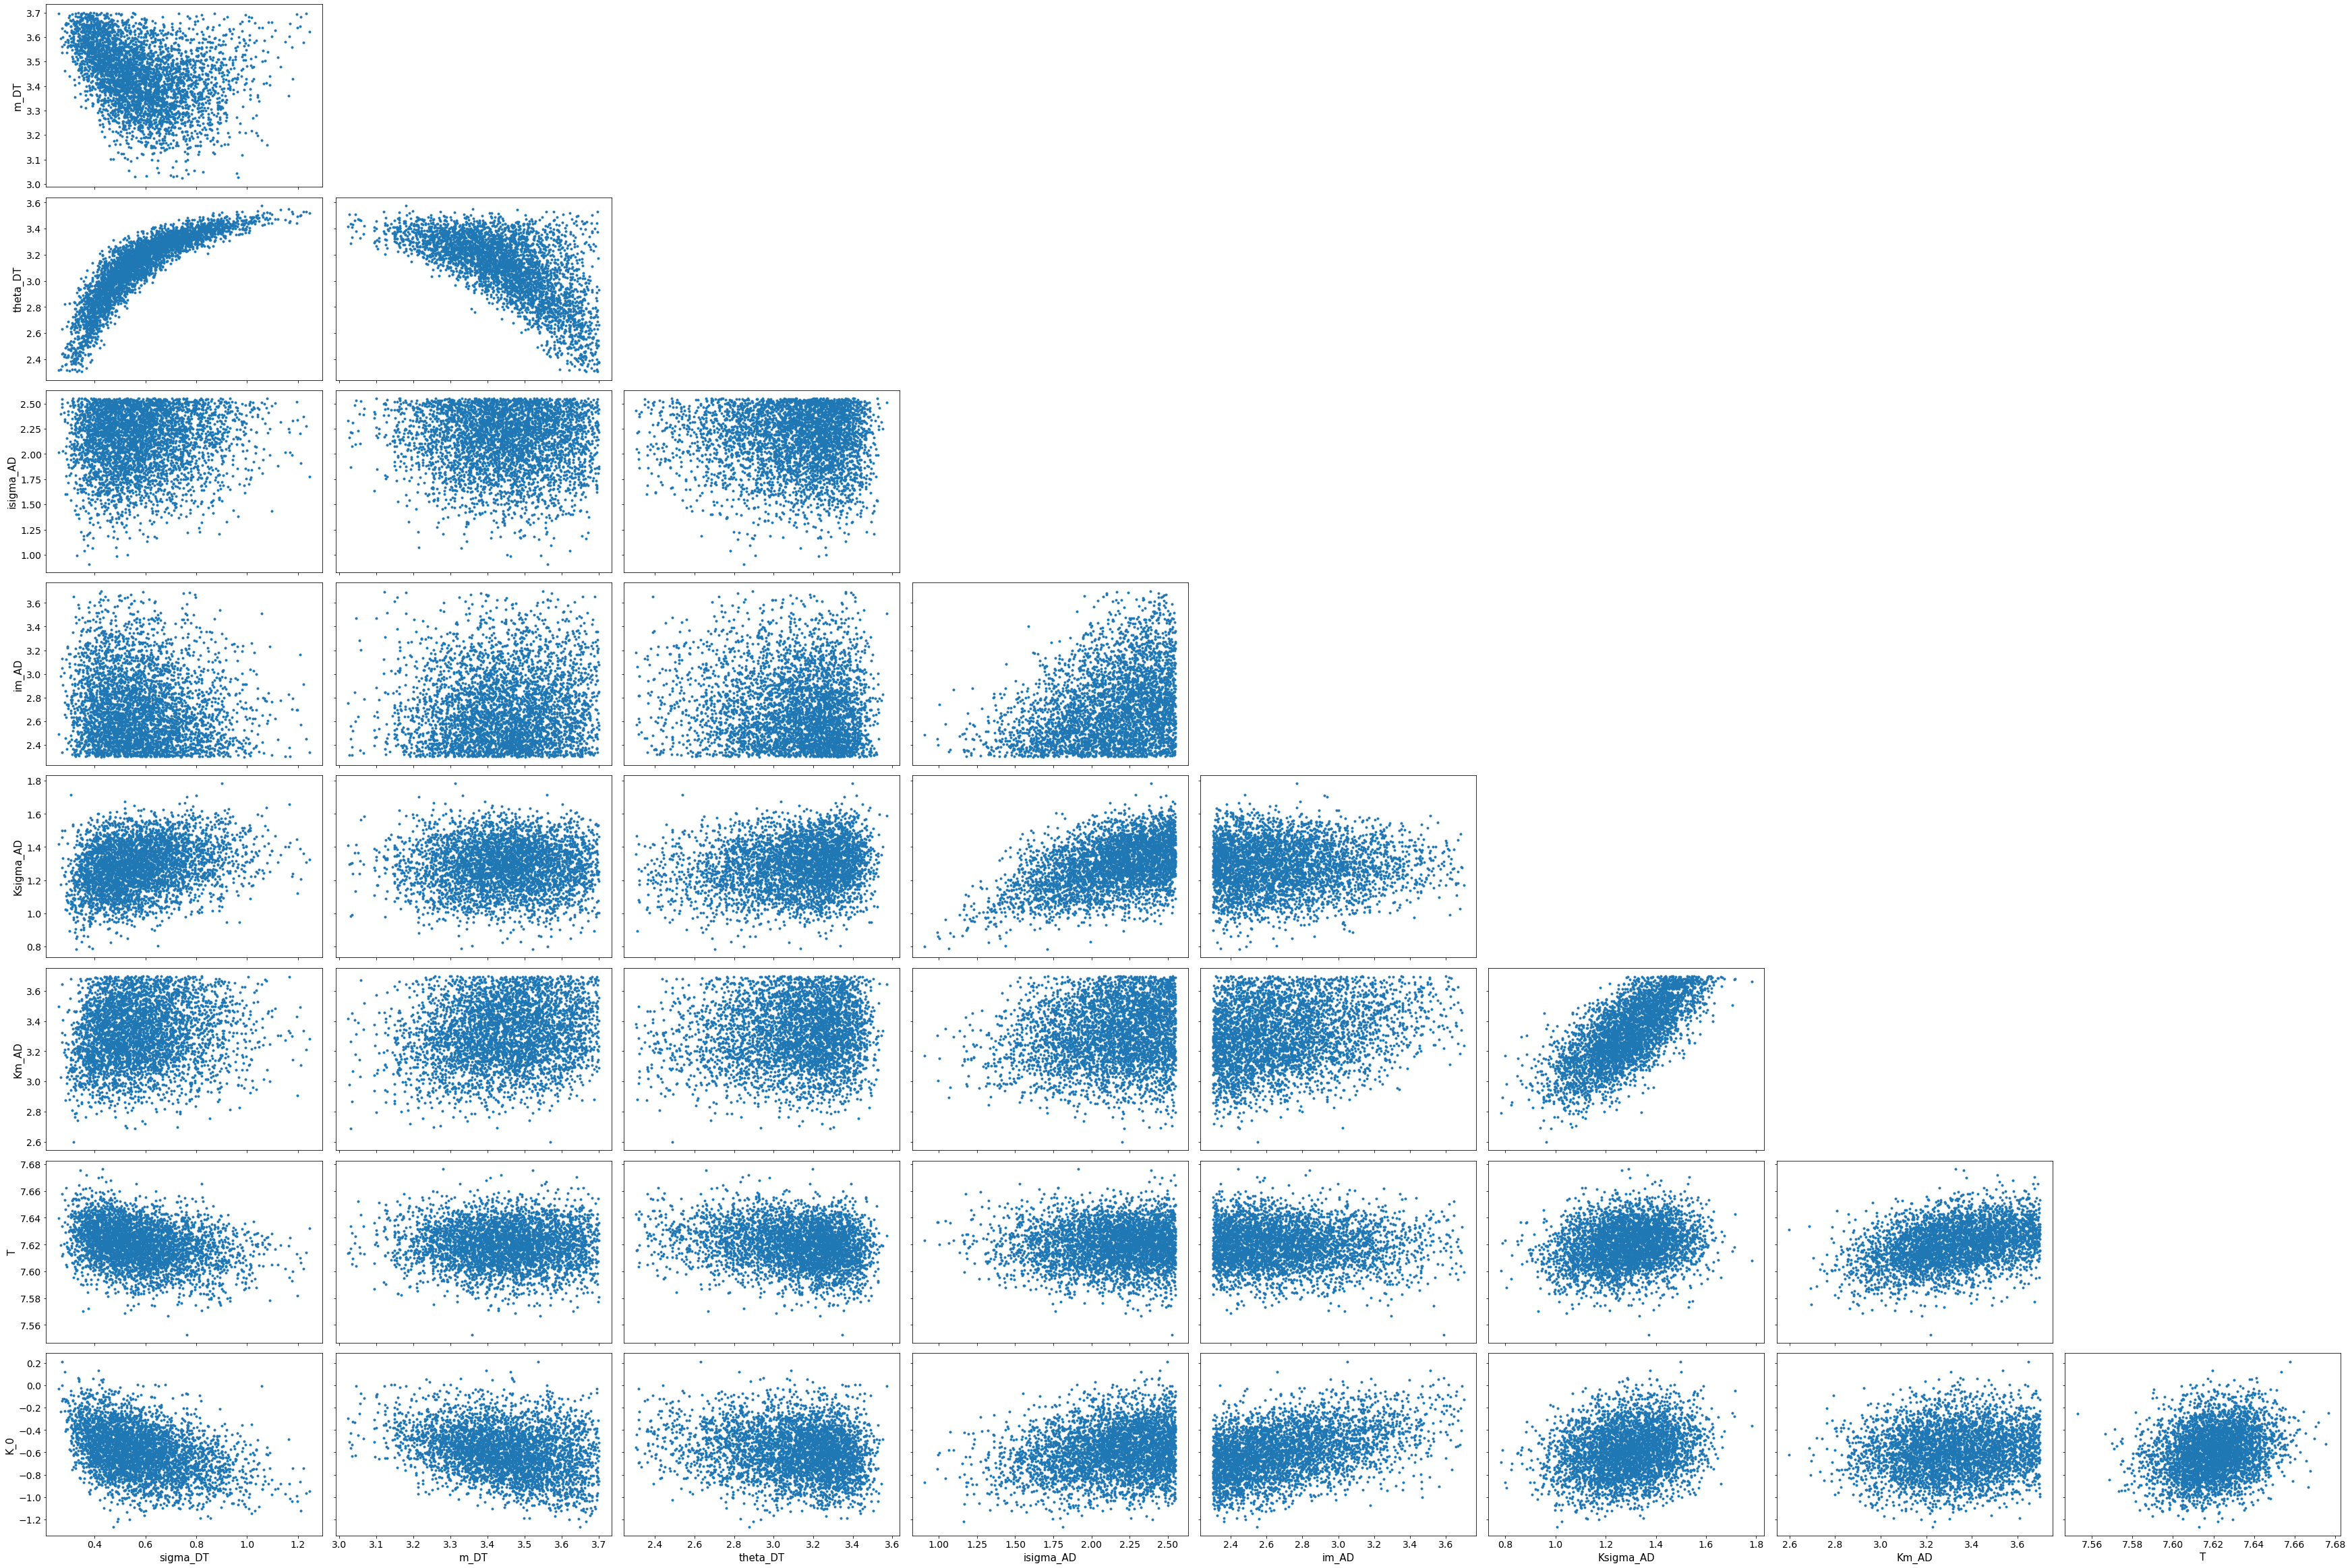

In [18]:
pm.pairplot(tracesimple, var_names=simplenames, divergences=True);

# GP and conditional GP

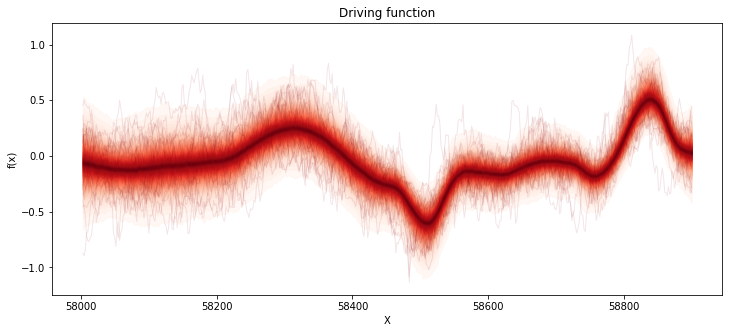

In [19]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, tracetransfer["f"], Xf);
#plot_gp_dist(ax, resu["f"], Xf);
# plot the data and the true latent function
#plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("f(x)");
plt.title("Driving function");

In [ ]:
n_new = 1000
X_new = np.linspace(min(Xf), max(Xf), n_new)

# add the GP conditional to the model, given the new X values
with convmodel:
    f_J = gp.conditional("f_J", X_new)

# Sample from the GP conditional distribution
with convmodel:
    pred_samples = pm.sample_posterior_predictive(tracesimple, vars=[f_J], samples=1000)

In [ ]:
#Calculate the mean and standard deviation of the traces. 
mu = np.zeros(len(X_new))
sd = np.zeros(len(X_new))

for i in range(0,len(X_new)):
    mu[i] = np.mean(pred_samples["f_J"][:,i])
    sd[i] = np.std(pred_samples["f_J"][:,i])

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 1σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 1σ region");
plt.plot(X_new, mu + 1*sd, 'r', lw=1); plt.plot(X_new, mu - 1*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 1*sd, mu + 1*sd, color="r", alpha=0.5)
#plt.errorbar(XJ,mu,sd,fmt='r.',label='Driving function value at data points')

# plot original data and true function
#plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
#plt.errorbar(X, y, yerr,fmt='.',label="observed data")

plt.xlabel("t");
plt.ylabel("diffmag")
plt.title("predictive mean and 1σ interval"); plt.legend();
print(np.mean(sd))

# Test

In [ ]:
xt=np.linspace(0,100,99)
yt=10.0*xt+4.0
comp=np.convolve(xt,yt,'same')
yterr=np.random.rand(99)
print(yterr)
with pm.Model() as test:
    
    a=pm.Uniform('a',lower=7.5,upper=20.0)
    b=pm.Uniform('b',lower=a/10.0,upper=a/2.0)
    xin=xt.reshape(1,1,99,1)
    muy=a*xin+b
    compa=theano.tensor.nnet.conv2d(xin,muy,border_mode='half')
    
    likelihood = pm.Normal('y', mu=compa[0,0,:,0], sigma=yterr, observed=comp)

    trace = pm.sample(4000,tune=1000,init='advi+adapt_diag',chains=2,cores=8)

In [ ]:
pm.traceplot(trace)

In [ ]:
pm.summary(trace)